# Sciplex Dose

In [1]:
ood_seed = 8

In [2]:
num_ood = 1

In [3]:
import warnings
import os
import sys
import gc
import warnings

In [4]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [7]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [8]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [9]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Nutlin', '10.0'), 657)

Removed datapoint: 657


In [10]:
adata

AnnData object with n_obs × n_vars = 14154 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [14]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: f6f7bfb7
Name: scruffy-looking-emperor-272
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/f6f7bfb7
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_004935-f6f7bfb7/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1733,1608,1425,1740,1415,1008,1426,969
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1558,3528,1679,2826,1733
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 422,353,367,431,375,275,341,266
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 381,940,424,663,422
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:12<2:00:32, 12.07s/it]

Epoch 1/600:   0%|          | 1/600 [00:12<2:00:32, 12.07s/it, v_num=b7_1, total_loss_train=2.68e+3, kl_local_train=30.7]

Epoch 2/600:   0%|          | 1/600 [00:12<2:00:32, 12.07s/it, v_num=b7_1, total_loss_train=2.68e+3, kl_local_train=30.7]

Epoch 2/600:   0%|          | 2/600 [00:23<1:56:08, 11.65s/it, v_num=b7_1, total_loss_train=2.68e+3, kl_local_train=30.7]

Epoch 2/600:   0%|          | 2/600 [00:23<1:56:08, 11.65s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=58.5]

Epoch 3/600:   0%|          | 2/600 [00:23<1:56:08, 11.65s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=58.5]

Epoch 3/600:   0%|          | 3/600 [00:34<1:54:26, 11.50s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=58.5]

Epoch 3/600:   0%|          | 3/600 [00:34<1:54:26, 11.50s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=64.8] 

Epoch 4/600:   0%|          | 3/600 [00:34<1:54:26, 11.50s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=64.8]

Epoch 4/600:   1%|          | 4/600 [00:46<1:53:32, 11.43s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=64.8]

Epoch 4/600:   1%|          | 4/600 [00:46<1:53:32, 11.43s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=66.5]

Epoch 5/600:   1%|          | 4/600 [00:46<1:53:32, 11.43s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=66.5]

Epoch 5/600:   1%|          | 5/600 [00:57<1:54:16, 11.52s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=66.5]

Epoch 5/600:   1%|          | 5/600 [00:57<1:54:16, 11.52s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=65.7]

Epoch 6/600:   1%|          | 5/600 [00:58<1:54:16, 11.52s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=65.7]

Epoch 6/600:   1%|          | 6/600 [01:08<1:52:09, 11.33s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=65.7]

Epoch 6/600:   1%|          | 6/600 [01:08<1:52:09, 11.33s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 7/600:   1%|          | 6/600 [01:08<1:52:09, 11.33s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 7/600:   1%|          | 7/600 [01:19<1:49:06, 11.04s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 7/600:   1%|          | 7/600 [01:19<1:49:06, 11.04s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 8/600:   1%|          | 7/600 [01:19<1:49:06, 11.04s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 8/600:   1%|▏         | 8/600 [01:29<1:46:49, 10.83s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 8/600:   1%|▏         | 8/600 [01:29<1:46:49, 10.83s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298] 

Epoch 9/600:   1%|▏         | 8/600 [01:29<1:46:49, 10.83s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 9/600:   2%|▏         | 9/600 [01:39<1:45:11, 10.68s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 9/600:   2%|▏         | 9/600 [01:39<1:45:11, 10.68s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 10/600:   2%|▏         | 9/600 [01:39<1:45:11, 10.68s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 10/600:   2%|▏         | 10/600 [01:50<1:45:37, 10.74s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 10/600:   2%|▏         | 10/600 [01:50<1:45:37, 10.74s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 11/600:   2%|▏         | 10/600 [01:51<1:45:37, 10.74s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 11/600:   2%|▏         | 11/600 [02:01<1:45:53, 10.79s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0402, metric_mi|condition_train=0.0298]

Epoch 11/600:   2%|▏         | 11/600 [02:01<1:45:53, 10.79s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 12/600:   2%|▏         | 11/600 [02:01<1:45:53, 10.79s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 12/600:   2%|▏         | 12/600 [02:11<1:44:22, 10.65s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 12/600:   2%|▏         | 12/600 [02:11<1:44:22, 10.65s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 13/600:   2%|▏         | 12/600 [02:12<1:44:22, 10.65s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 13/600:   2%|▏         | 13/600 [02:22<1:43:15, 10.55s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 13/600:   2%|▏         | 13/600 [02:22<1:43:15, 10.55s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 14/600:   2%|▏         | 13/600 [02:22<1:43:15, 10.55s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 14/600:   2%|▏         | 14/600 [02:32<1:42:31, 10.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 14/600:   2%|▏         | 14/600 [02:32<1:42:31, 10.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=39, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]  

Epoch 15/600:   2%|▏         | 14/600 [02:32<1:42:31, 10.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=39, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 15/600:   2%|▎         | 15/600 [02:43<1:42:59, 10.56s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=39, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 15/600:   2%|▎         | 15/600 [02:43<1:42:59, 10.56s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 16/600:   2%|▎         | 15/600 [02:43<1:42:59, 10.56s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 16/600:   3%|▎         | 16/600 [02:54<1:43:53, 10.67s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0441, metric_mi|condition_train=0.0585]

Epoch 16/600:   3%|▎         | 16/600 [02:54<1:43:53, 10.67s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138] 

Epoch 17/600:   3%|▎         | 16/600 [02:54<1:43:53, 10.67s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 17/600:   3%|▎         | 17/600 [03:04<1:42:52, 10.59s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 17/600:   3%|▎         | 17/600 [03:04<1:42:52, 10.59s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 18/600:   3%|▎         | 17/600 [03:04<1:42:52, 10.59s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 18/600:   3%|▎         | 18/600 [03:15<1:42:09, 10.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 18/600:   3%|▎         | 18/600 [03:15<1:42:09, 10.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 19/600:   3%|▎         | 18/600 [03:15<1:42:09, 10.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 19/600:   3%|▎         | 19/600 [03:25<1:41:39, 10.50s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 19/600:   3%|▎         | 19/600 [03:25<1:41:39, 10.50s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]  

Epoch 20/600:   3%|▎         | 19/600 [03:25<1:41:39, 10.50s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 20/600:   3%|▎         | 20/600 [03:36<1:42:34, 10.61s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 20/600:   3%|▎         | 20/600 [03:36<1:42:34, 10.61s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 21/600:   3%|▎         | 20/600 [03:36<1:42:34, 10.61s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 21/600:   4%|▎         | 21/600 [03:48<1:45:46, 10.96s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.138]

Epoch 21/600:   4%|▎         | 21/600 [03:48<1:45:46, 10.96s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 22/600:   4%|▎         | 21/600 [03:48<1:45:46, 10.96s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 22/600:   4%|▎         | 22/600 [03:58<1:43:55, 10.79s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 22/600:   4%|▎         | 22/600 [03:58<1:43:55, 10.79s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 23/600:   4%|▎         | 22/600 [03:58<1:43:55, 10.79s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 23/600:   4%|▍         | 23/600 [04:08<1:42:35, 10.67s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 23/600:   4%|▍         | 23/600 [04:08<1:42:35, 10.67s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 24/600:   4%|▍         | 23/600 [04:08<1:42:35, 10.67s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 24/600:   4%|▍         | 24/600 [04:19<1:41:34, 10.58s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 24/600:   4%|▍         | 24/600 [04:19<1:41:34, 10.58s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 25/600:   4%|▍         | 24/600 [04:19<1:41:34, 10.58s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 25/600:   4%|▍         | 25/600 [04:30<1:43:28, 10.80s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 25/600:   4%|▍         | 25/600 [04:30<1:43:28, 10.80s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 26/600:   4%|▍         | 25/600 [04:31<1:43:28, 10.80s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 26/600:   4%|▍         | 26/600 [04:42<1:46:12, 11.10s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0634, metric_mi|condition_train=0.136]

Epoch 26/600:   4%|▍         | 26/600 [04:42<1:46:12, 11.10s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]  

Epoch 27/600:   4%|▍         | 26/600 [04:42<1:46:12, 11.10s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 27/600:   4%|▍         | 27/600 [04:53<1:46:51, 11.19s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 27/600:   4%|▍         | 27/600 [04:53<1:46:51, 11.19s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 28/600:   4%|▍         | 27/600 [04:53<1:46:51, 11.19s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 28/600:   5%|▍         | 28/600 [05:05<1:47:18, 11.26s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 28/600:   5%|▍         | 28/600 [05:05<1:47:18, 11.26s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 29/600:   5%|▍         | 28/600 [05:05<1:47:18, 11.26s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 29/600:   5%|▍         | 29/600 [05:16<1:47:25, 11.29s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 29/600:   5%|▍         | 29/600 [05:16<1:47:25, 11.29s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 30/600:   5%|▍         | 29/600 [05:16<1:47:25, 11.29s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 30/600:   5%|▌         | 30/600 [05:28<1:48:22, 11.41s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=79.6, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 30/600:   5%|▌         | 30/600 [05:28<1:48:22, 11.41s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 31/600:   5%|▌         | 30/600 [05:28<1:48:22, 11.41s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 31/600:   5%|▌         | 31/600 [05:40<1:49:15, 11.52s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0615, metric_mi|condition_train=0.13]

Epoch 31/600:   5%|▌         | 31/600 [05:40<1:49:15, 11.52s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=82, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132] 

Epoch 32/600:   5%|▌         | 31/600 [05:40<1:49:15, 11.52s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=82, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 32/600:   5%|▌         | 32/600 [05:51<1:48:32, 11.47s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=82, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 32/600:   5%|▌         | 32/600 [05:51<1:48:32, 11.47s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=87, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 33/600:   5%|▌         | 32/600 [05:51<1:48:32, 11.47s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=87, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 33/600:   6%|▌         | 33/600 [06:02<1:47:50, 11.41s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=87, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 33/600:   6%|▌         | 33/600 [06:02<1:47:50, 11.41s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 34/600:   6%|▌         | 33/600 [06:02<1:47:50, 11.41s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 34/600:   6%|▌         | 34/600 [06:14<1:47:43, 11.42s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=88.3, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 34/600:   6%|▌         | 34/600 [06:14<1:47:43, 11.42s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 35/600:   6%|▌         | 34/600 [06:14<1:47:43, 11.42s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 35/600:   6%|▌         | 35/600 [06:25<1:48:06, 11.48s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 35/600:   6%|▌         | 35/600 [06:25<1:48:06, 11.48s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 36/600:   6%|▌         | 35/600 [06:26<1:48:06, 11.48s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 36/600:   6%|▌         | 36/600 [06:37<1:48:25, 11.53s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.132]

Epoch 36/600:   6%|▌         | 36/600 [06:37<1:48:25, 11.53s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]  

Epoch 37/600:   6%|▌         | 36/600 [06:37<1:48:25, 11.53s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 37/600:   6%|▌         | 37/600 [06:48<1:47:12, 11.43s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 37/600:   6%|▌         | 37/600 [06:48<1:47:12, 11.43s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=99.4, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 38/600:   6%|▌         | 37/600 [06:48<1:47:12, 11.43s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=99.4, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 38/600:   6%|▋         | 38/600 [06:59<1:46:24, 11.36s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=99.4, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 38/600:   6%|▋         | 38/600 [06:59<1:46:24, 11.36s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14] 

Epoch 39/600:   6%|▋         | 38/600 [06:59<1:46:24, 11.36s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 39/600:   6%|▋         | 39/600 [07:11<1:45:52, 11.32s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 39/600:   6%|▋         | 39/600 [07:11<1:45:52, 11.32s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=107, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 40/600:   6%|▋         | 39/600 [07:11<1:45:52, 11.32s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=107, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 40/600:   7%|▋         | 40/600 [07:22<1:46:22, 11.40s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=107, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 40/600:   7%|▋         | 40/600 [07:22<1:46:22, 11.40s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=110, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 41/600:   7%|▋         | 40/600 [07:23<1:46:22, 11.40s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=110, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 41/600:   7%|▋         | 41/600 [07:34<1:47:13, 11.51s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=110, metric_mi|dose_training_train=0.064, metric_mi|condition_train=0.14]

Epoch 41/600:   7%|▋         | 41/600 [07:34<1:47:13, 11.51s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 42/600:   7%|▋         | 41/600 [07:34<1:47:13, 11.51s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 42/600:   7%|▋         | 42/600 [07:45<1:46:21, 11.44s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 42/600:   7%|▋         | 42/600 [07:45<1:46:21, 11.44s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 43/600:   7%|▋         | 42/600 [07:45<1:46:21, 11.44s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 43/600:   7%|▋         | 43/600 [07:56<1:45:41, 11.39s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 43/600:   7%|▋         | 43/600 [07:56<1:45:41, 11.39s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=110, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 44/600:   7%|▋         | 43/600 [07:56<1:45:41, 11.39s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=110, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 44/600:   7%|▋         | 44/600 [08:08<1:45:11, 11.35s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=110, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 44/600:   7%|▋         | 44/600 [08:08<1:45:11, 11.35s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=111, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 45/600:   7%|▋         | 44/600 [08:08<1:45:11, 11.35s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=111, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 45/600:   8%|▊         | 45/600 [08:19<1:45:37, 11.42s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=111, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 45/600:   8%|▊         | 45/600 [08:19<1:45:37, 11.42s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 46/600:   8%|▊         | 45/600 [08:20<1:45:37, 11.42s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 46/600:   8%|▊         | 46/600 [08:31<1:46:26, 11.53s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.144]

Epoch 46/600:   8%|▊         | 46/600 [08:31<1:46:26, 11.53s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=114, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 47/600:   8%|▊         | 46/600 [08:31<1:46:26, 11.53s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=114, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 47/600:   8%|▊         | 47/600 [08:42<1:45:33, 11.45s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=114, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 47/600:   8%|▊         | 47/600 [08:42<1:45:33, 11.45s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=116, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 48/600:   8%|▊         | 47/600 [08:42<1:45:33, 11.45s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=116, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 48/600:   8%|▊         | 48/600 [08:54<1:44:54, 11.40s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=116, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 48/600:   8%|▊         | 48/600 [08:54<1:44:54, 11.40s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=119, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 49/600:   8%|▊         | 48/600 [08:54<1:44:54, 11.40s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=119, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 49/600:   8%|▊         | 49/600 [09:05<1:44:24, 11.37s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=119, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 49/600:   8%|▊         | 49/600 [09:05<1:44:24, 11.37s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=121, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 50/600:   8%|▊         | 49/600 [09:05<1:44:24, 11.37s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=121, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 50/600:   8%|▊         | 50/600 [09:16<1:44:43, 11.43s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=121, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 50/600:   8%|▊         | 50/600 [09:16<1:44:43, 11.43s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=121, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 51/600:   8%|▊         | 50/600 [09:17<1:44:43, 11.43s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=121, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 51/600:   8%|▊         | 51/600 [09:28<1:45:33, 11.54s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=121, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.154]

Epoch 51/600:   8%|▊         | 51/600 [09:28<1:45:33, 11.54s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=127, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 52/600:   8%|▊         | 51/600 [09:28<1:45:33, 11.54s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=127, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 52/600:   9%|▊         | 52/600 [09:40<1:44:39, 11.46s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=127, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 52/600:   9%|▊         | 52/600 [09:40<1:44:39, 11.46s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=126, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 53/600:   9%|▊         | 52/600 [09:40<1:44:39, 11.46s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=126, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 53/600:   9%|▉         | 53/600 [09:51<1:44:01, 11.41s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=126, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 53/600:   9%|▉         | 53/600 [09:51<1:44:01, 11.41s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=129, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 54/600:   9%|▉         | 53/600 [09:51<1:44:01, 11.41s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=129, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 54/600:   9%|▉         | 54/600 [10:02<1:43:26, 11.37s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=129, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 54/600:   9%|▉         | 54/600 [10:02<1:43:26, 11.37s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=129, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 55/600:   9%|▉         | 54/600 [10:02<1:43:26, 11.37s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=129, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 55/600:   9%|▉         | 55/600 [10:14<1:43:51, 11.43s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=129, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 55/600:   9%|▉         | 55/600 [10:14<1:43:51, 11.43s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=130, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 56/600:   9%|▉         | 55/600 [10:14<1:43:51, 11.43s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=130, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 56/600:   9%|▉         | 56/600 [10:26<1:44:49, 11.56s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=130, metric_mi|dose_training_train=0.0716, metric_mi|condition_train=0.156]

Epoch 56/600:   9%|▉         | 56/600 [10:26<1:44:49, 11.56s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=133, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 57/600:   9%|▉         | 56/600 [10:26<1:44:49, 11.56s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=133, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 57/600:  10%|▉         | 57/600 [10:37<1:43:48, 11.47s/it, v_num=b7_1, total_loss_train=2.27e+3, kl_local_train=133, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 57/600:  10%|▉         | 57/600 [10:37<1:43:48, 11.47s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=134, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 58/600:  10%|▉         | 57/600 [10:37<1:43:48, 11.47s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=134, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 58/600:  10%|▉         | 58/600 [10:48<1:42:57, 11.40s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=134, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 58/600:  10%|▉         | 58/600 [10:48<1:42:57, 11.40s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=134, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 59/600:  10%|▉         | 58/600 [10:48<1:42:57, 11.40s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=134, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 59/600:  10%|▉         | 59/600 [10:59<1:42:18, 11.35s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=134, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 59/600:  10%|▉         | 59/600 [10:59<1:42:18, 11.35s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=132, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 60/600:  10%|▉         | 59/600 [10:59<1:42:18, 11.35s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=132, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 60/600:  10%|█         | 60/600 [11:11<1:42:59, 11.44s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=132, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 60/600:  10%|█         | 60/600 [11:11<1:42:59, 11.44s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=131, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 61/600:  10%|█         | 60/600 [11:11<1:42:59, 11.44s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=131, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 61/600:  10%|█         | 61/600 [11:23<1:43:47, 11.55s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=131, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.163]

Epoch 61/600:  10%|█         | 61/600 [11:23<1:43:47, 11.55s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=130, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 62/600:  10%|█         | 61/600 [11:23<1:43:47, 11.55s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=130, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 62/600:  10%|█         | 62/600 [11:34<1:42:46, 11.46s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=130, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 62/600:  10%|█         | 62/600 [11:34<1:42:46, 11.46s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=127, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 63/600:  10%|█         | 62/600 [11:34<1:42:46, 11.46s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=127, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 63/600:  10%|█         | 63/600 [11:45<1:42:01, 11.40s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=127, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 63/600:  10%|█         | 63/600 [11:45<1:42:01, 11.40s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=126, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 64/600:  10%|█         | 63/600 [11:45<1:42:01, 11.40s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=126, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 64/600:  11%|█         | 64/600 [11:57<1:41:25, 11.35s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=126, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 64/600:  11%|█         | 64/600 [11:57<1:41:25, 11.35s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=125, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 65/600:  11%|█         | 64/600 [11:57<1:41:25, 11.35s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=125, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 65/600:  11%|█         | 65/600 [12:08<1:41:42, 11.41s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=125, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 65/600:  11%|█         | 65/600 [12:08<1:41:42, 11.41s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=128, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 66/600:  11%|█         | 65/600 [12:09<1:41:42, 11.41s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=128, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 66/600:  11%|█         | 66/600 [12:20<1:42:27, 11.51s/it, v_num=b7_1, total_loss_train=2.26e+3, kl_local_train=128, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.165]

Epoch 66/600:  11%|█         | 66/600 [12:20<1:42:27, 11.51s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=128, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 67/600:  11%|█         | 66/600 [12:20<1:42:27, 11.51s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=128, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 67/600:  11%|█         | 67/600 [12:31<1:41:34, 11.43s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=128, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 67/600:  11%|█         | 67/600 [12:31<1:41:34, 11.43s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=125, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 68/600:  11%|█         | 67/600 [12:31<1:41:34, 11.43s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=125, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 68/600:  11%|█▏        | 68/600 [12:42<1:40:53, 11.38s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=125, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 68/600:  11%|█▏        | 68/600 [12:42<1:40:53, 11.38s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=126, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 69/600:  11%|█▏        | 68/600 [12:42<1:40:53, 11.38s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=126, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 69/600:  12%|█▏        | 69/600 [12:54<1:40:22, 11.34s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=126, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 69/600:  12%|█▏        | 69/600 [12:54<1:40:22, 11.34s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=125, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 70/600:  12%|█▏        | 69/600 [12:54<1:40:22, 11.34s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=125, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 70/600:  12%|█▏        | 70/600 [13:05<1:40:42, 11.40s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=125, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 70/600:  12%|█▏        | 70/600 [13:05<1:40:42, 11.40s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=121, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 71/600:  12%|█▏        | 70/600 [13:06<1:40:42, 11.40s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=121, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 71/600:  12%|█▏        | 71/600 [13:17<1:41:25, 11.50s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=121, metric_mi|dose_training_train=0.0805, metric_mi|condition_train=0.169]

Epoch 71/600:  12%|█▏        | 71/600 [13:17<1:41:25, 11.50s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=123, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 72/600:  12%|█▏        | 71/600 [13:17<1:41:25, 11.50s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=123, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 72/600:  12%|█▏        | 72/600 [13:28<1:40:31, 11.42s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=123, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 72/600:  12%|█▏        | 72/600 [13:28<1:40:31, 11.42s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=124, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 73/600:  12%|█▏        | 72/600 [13:28<1:40:31, 11.42s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=124, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 73/600:  12%|█▏        | 73/600 [13:39<1:39:51, 11.37s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=124, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 73/600:  12%|█▏        | 73/600 [13:39<1:39:51, 11.37s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=124, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 74/600:  12%|█▏        | 73/600 [13:39<1:39:51, 11.37s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=124, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 74/600:  12%|█▏        | 74/600 [13:51<1:39:20, 11.33s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=124, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 74/600:  12%|█▏        | 74/600 [13:51<1:39:20, 11.33s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=123, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 75/600:  12%|█▏        | 74/600 [13:51<1:39:20, 11.33s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=123, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 75/600:  12%|█▎        | 75/600 [14:02<1:39:43, 11.40s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=123, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 75/600:  12%|█▎        | 75/600 [14:02<1:39:43, 11.40s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=119, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 76/600:  12%|█▎        | 75/600 [14:03<1:39:43, 11.40s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=119, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 76/600:  13%|█▎        | 76/600 [14:14<1:40:32, 11.51s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=119, metric_mi|dose_training_train=0.0836, metric_mi|condition_train=0.177]

Epoch 76/600:  13%|█▎        | 76/600 [14:14<1:40:32, 11.51s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=122, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 77/600:  13%|█▎        | 76/600 [14:14<1:40:32, 11.51s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=122, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 77/600:  13%|█▎        | 77/600 [14:25<1:39:40, 11.43s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=122, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 77/600:  13%|█▎        | 77/600 [14:25<1:39:40, 11.43s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=121, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 78/600:  13%|█▎        | 77/600 [14:25<1:39:40, 11.43s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=121, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 78/600:  13%|█▎        | 78/600 [14:36<1:39:01, 11.38s/it, v_num=b7_1, total_loss_train=2.25e+3, kl_local_train=121, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 78/600:  13%|█▎        | 78/600 [14:36<1:39:01, 11.38s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=123, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 79/600:  13%|█▎        | 78/600 [14:36<1:39:01, 11.38s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=123, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 79/600:  13%|█▎        | 79/600 [14:48<1:38:35, 11.35s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=123, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 79/600:  13%|█▎        | 79/600 [14:48<1:38:35, 11.35s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 80/600:  13%|█▎        | 79/600 [14:48<1:38:35, 11.35s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 80/600:  13%|█▎        | 80/600 [14:59<1:38:56, 11.42s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 80/600:  13%|█▎        | 80/600 [14:59<1:38:56, 11.42s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 81/600:  13%|█▎        | 80/600 [15:00<1:38:56, 11.42s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 81/600:  14%|█▎        | 81/600 [15:11<1:39:56, 11.55s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.0867, metric_mi|condition_train=0.179]

Epoch 81/600:  14%|█▎        | 81/600 [15:11<1:39:56, 11.55s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=118, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 82/600:  14%|█▎        | 81/600 [15:11<1:39:56, 11.55s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=118, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 82/600:  14%|█▎        | 82/600 [15:23<1:39:24, 11.52s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=118, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 82/600:  14%|█▎        | 82/600 [15:23<1:39:24, 11.52s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=115, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 83/600:  14%|█▎        | 82/600 [15:23<1:39:24, 11.52s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=115, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 83/600:  14%|█▍        | 83/600 [15:34<1:38:52, 11.47s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=115, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 83/600:  14%|█▍        | 83/600 [15:34<1:38:52, 11.47s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 84/600:  14%|█▍        | 83/600 [15:34<1:38:52, 11.47s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 84/600:  14%|█▍        | 84/600 [15:45<1:38:22, 11.44s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 84/600:  14%|█▍        | 84/600 [15:45<1:38:22, 11.44s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 85/600:  14%|█▍        | 84/600 [15:45<1:38:22, 11.44s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 85/600:  14%|█▍        | 85/600 [15:57<1:38:45, 11.51s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 85/600:  14%|█▍        | 85/600 [15:57<1:38:45, 11.51s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 86/600:  14%|█▍        | 85/600 [15:57<1:38:45, 11.51s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 86/600:  14%|█▍        | 86/600 [16:09<1:39:39, 11.63s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.0905, metric_mi|condition_train=0.185]

Epoch 86/600:  14%|█▍        | 86/600 [16:09<1:39:39, 11.63s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 87/600:  14%|█▍        | 86/600 [16:09<1:39:39, 11.63s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 87/600:  14%|█▍        | 87/600 [16:20<1:39:12, 11.60s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 87/600:  14%|█▍        | 87/600 [16:20<1:39:12, 11.60s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 88/600:  14%|█▍        | 87/600 [16:20<1:39:12, 11.60s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 88/600:  15%|█▍        | 88/600 [16:32<1:38:37, 11.56s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 88/600:  15%|█▍        | 88/600 [16:32<1:38:37, 11.56s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 89/600:  15%|█▍        | 88/600 [16:32<1:38:37, 11.56s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 89/600:  15%|█▍        | 89/600 [16:43<1:37:55, 11.50s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 89/600:  15%|█▍        | 89/600 [16:43<1:37:55, 11.50s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=110, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 90/600:  15%|█▍        | 89/600 [16:43<1:37:55, 11.50s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=110, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 90/600:  15%|█▌        | 90/600 [16:55<1:38:13, 11.55s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=110, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 90/600:  15%|█▌        | 90/600 [16:55<1:38:13, 11.55s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 91/600:  15%|█▌        | 90/600 [16:55<1:38:13, 11.55s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 91/600:  15%|█▌        | 91/600 [17:07<1:38:51, 11.65s/it, v_num=b7_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.191]

Epoch 91/600:  15%|█▌        | 91/600 [17:07<1:38:51, 11.65s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 92/600:  15%|█▌        | 91/600 [17:07<1:38:51, 11.65s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 92/600:  15%|█▌        | 92/600 [17:18<1:37:56, 11.57s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 92/600:  15%|█▌        | 92/600 [17:18<1:37:56, 11.57s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 93/600:  15%|█▌        | 92/600 [17:18<1:37:56, 11.57s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 93/600:  16%|█▌        | 93/600 [17:30<1:37:12, 11.50s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 93/600:  16%|█▌        | 93/600 [17:30<1:37:12, 11.50s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 94/600:  16%|█▌        | 93/600 [17:30<1:37:12, 11.50s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 94/600:  16%|█▌        | 94/600 [17:41<1:36:36, 11.46s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 94/600:  16%|█▌        | 94/600 [17:41<1:36:36, 11.46s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 95/600:  16%|█▌        | 94/600 [17:41<1:36:36, 11.46s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 95/600:  16%|█▌        | 95/600 [17:53<1:36:58, 11.52s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 95/600:  16%|█▌        | 95/600 [17:53<1:36:58, 11.52s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 96/600:  16%|█▌        | 95/600 [17:53<1:36:58, 11.52s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 96/600:  16%|█▌        | 96/600 [18:04<1:37:43, 11.63s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.0955, metric_mi|condition_train=0.191]

Epoch 96/600:  16%|█▌        | 96/600 [18:04<1:37:43, 11.63s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=110, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 97/600:  16%|█▌        | 96/600 [18:04<1:37:43, 11.63s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=110, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 97/600:  16%|█▌        | 97/600 [18:16<1:36:53, 11.56s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=110, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 97/600:  16%|█▌        | 97/600 [18:16<1:36:53, 11.56s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=108, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 98/600:  16%|█▌        | 97/600 [18:16<1:36:53, 11.56s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=108, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 98/600:  16%|█▋        | 98/600 [18:27<1:36:15, 11.50s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=108, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 98/600:  16%|█▋        | 98/600 [18:27<1:36:15, 11.50s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 99/600:  16%|█▋        | 98/600 [18:27<1:36:15, 11.50s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 99/600:  16%|█▋        | 99/600 [18:39<1:35:45, 11.47s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 99/600:  16%|█▋        | 99/600 [18:39<1:35:45, 11.47s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 100/600:  16%|█▋        | 99/600 [18:39<1:35:45, 11.47s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 100/600:  17%|█▋        | 100/600 [18:50<1:36:00, 11.52s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 100/600:  17%|█▋        | 100/600 [18:50<1:36:00, 11.52s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 101/600:  17%|█▋        | 100/600 [18:51<1:36:00, 11.52s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 101/600:  17%|█▋        | 101/600 [19:02<1:36:44, 11.63s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.192]

Epoch 101/600:  17%|█▋        | 101/600 [19:02<1:36:44, 11.63s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194] 

Epoch 102/600:  17%|█▋        | 101/600 [19:02<1:36:44, 11.63s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 102/600:  17%|█▋        | 102/600 [19:13<1:35:54, 11.56s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 102/600:  17%|█▋        | 102/600 [19:13<1:35:54, 11.56s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=108, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 103/600:  17%|█▋        | 102/600 [19:14<1:35:54, 11.56s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=108, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 103/600:  17%|█▋        | 103/600 [19:25<1:35:19, 11.51s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=108, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 103/600:  17%|█▋        | 103/600 [19:25<1:35:19, 11.51s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 104/600:  17%|█▋        | 103/600 [19:25<1:35:19, 11.51s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 104/600:  17%|█▋        | 104/600 [19:36<1:34:49, 11.47s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=107, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 104/600:  17%|█▋        | 104/600 [19:36<1:34:49, 11.47s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 105/600:  17%|█▋        | 104/600 [19:36<1:34:49, 11.47s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 105/600:  18%|█▊        | 105/600 [19:48<1:35:05, 11.53s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=106, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 105/600:  18%|█▊        | 105/600 [19:48<1:35:05, 11.53s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 106/600:  18%|█▊        | 105/600 [19:48<1:35:05, 11.53s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 106/600:  18%|█▊        | 106/600 [20:00<1:36:01, 11.66s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.194]

Epoch 106/600:  18%|█▊        | 106/600 [20:00<1:36:01, 11.66s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=103, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 107/600:  18%|█▊        | 106/600 [20:00<1:36:01, 11.66s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=103, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 107/600:  18%|█▊        | 107/600 [20:11<1:35:20, 11.60s/it, v_num=b7_1, total_loss_train=2.23e+3, kl_local_train=103, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 107/600:  18%|█▊        | 107/600 [20:11<1:35:20, 11.60s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=102, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 108/600:  18%|█▊        | 107/600 [20:11<1:35:20, 11.60s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=102, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 108/600:  18%|█▊        | 108/600 [20:23<1:34:50, 11.57s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=102, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 108/600:  18%|█▊        | 108/600 [20:23<1:34:50, 11.57s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=101, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 109/600:  18%|█▊        | 108/600 [20:23<1:34:50, 11.57s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=101, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 109/600:  18%|█▊        | 109/600 [20:34<1:34:24, 11.54s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=101, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 109/600:  18%|█▊        | 109/600 [20:34<1:34:24, 11.54s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=99.6, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 110/600:  18%|█▊        | 109/600 [20:34<1:34:24, 11.54s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=99.6, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 110/600:  18%|█▊        | 110/600 [20:46<1:34:40, 11.59s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=99.6, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 110/600:  18%|█▊        | 110/600 [20:46<1:34:40, 11.59s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 111/600:  18%|█▊        | 110/600 [20:47<1:34:40, 11.59s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 111/600:  18%|█▊        | 111/600 [20:58<1:35:21, 11.70s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.198]

Epoch 111/600:  18%|█▊        | 111/600 [20:58<1:35:21, 11.70s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 112/600:  18%|█▊        | 111/600 [20:58<1:35:21, 11.70s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 112/600:  19%|█▊        | 112/600 [21:09<1:34:33, 11.63s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 112/600:  19%|█▊        | 112/600 [21:09<1:34:33, 11.63s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]  

Epoch 113/600:  19%|█▊        | 112/600 [21:09<1:34:33, 11.63s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 113/600:  19%|█▉        | 113/600 [21:21<1:34:03, 11.59s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 113/600:  19%|█▉        | 113/600 [21:21<1:34:03, 11.59s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 114/600:  19%|█▉        | 113/600 [21:21<1:34:03, 11.59s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 114/600:  19%|█▉        | 114/600 [21:33<1:33:48, 11.58s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=98.5, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 114/600:  19%|█▉        | 114/600 [21:33<1:33:48, 11.58s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=99.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 115/600:  19%|█▉        | 114/600 [21:33<1:33:48, 11.58s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=99.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 115/600:  19%|█▉        | 115/600 [21:44<1:33:52, 11.61s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=99.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 115/600:  19%|█▉        | 115/600 [21:44<1:33:52, 11.61s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 116/600:  19%|█▉        | 115/600 [21:45<1:33:52, 11.61s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 116/600:  19%|█▉        | 116/600 [21:56<1:34:31, 11.72s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=98.1, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.201]

Epoch 116/600:  19%|█▉        | 116/600 [21:56<1:34:31, 11.72s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]  

Epoch 117/600:  19%|█▉        | 116/600 [21:56<1:34:31, 11.72s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 117/600:  20%|█▉        | 117/600 [22:08<1:33:38, 11.63s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 117/600:  20%|█▉        | 117/600 [22:08<1:33:38, 11.63s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 118/600:  20%|█▉        | 117/600 [22:08<1:33:38, 11.63s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 118/600:  20%|█▉        | 118/600 [22:19<1:32:57, 11.57s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 118/600:  20%|█▉        | 118/600 [22:19<1:32:57, 11.57s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 119/600:  20%|█▉        | 118/600 [22:19<1:32:57, 11.57s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 119/600:  20%|█▉        | 119/600 [22:30<1:32:21, 11.52s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 119/600:  20%|█▉        | 119/600 [22:30<1:32:21, 11.52s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]  

Epoch 120/600:  20%|█▉        | 119/600 [22:30<1:32:21, 11.52s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 120/600:  20%|██        | 120/600 [22:42<1:32:32, 11.57s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 120/600:  20%|██        | 120/600 [22:42<1:32:32, 11.57s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 121/600:  20%|██        | 120/600 [22:43<1:32:32, 11.57s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 121/600:  20%|██        | 121/600 [22:54<1:33:12, 11.67s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97.6, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.197]

Epoch 121/600:  20%|██        | 121/600 [22:54<1:33:12, 11.67s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]  

Epoch 122/600:  20%|██        | 121/600 [22:54<1:33:12, 11.67s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 122/600:  20%|██        | 122/600 [23:05<1:32:22, 11.60s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 122/600:  20%|██        | 122/600 [23:05<1:32:22, 11.60s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 123/600:  20%|██        | 122/600 [23:05<1:32:22, 11.60s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 123/600:  20%|██        | 123/600 [23:17<1:31:46, 11.54s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 123/600:  20%|██        | 123/600 [23:17<1:31:46, 11.54s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 124/600:  20%|██        | 123/600 [23:17<1:31:46, 11.54s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 124/600:  21%|██        | 124/600 [23:28<1:31:16, 11.51s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 124/600:  21%|██        | 124/600 [23:28<1:31:16, 11.51s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=93, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]  

Epoch 125/600:  21%|██        | 124/600 [23:28<1:31:16, 11.51s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=93, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 125/600:  21%|██        | 125/600 [23:40<1:31:28, 11.55s/it, v_num=b7_1, total_loss_train=2.22e+3, kl_local_train=93, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 125/600:  21%|██        | 125/600 [23:40<1:31:28, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.2, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 126/600:  21%|██        | 125/600 [23:40<1:31:28, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.2, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 126/600:  21%|██        | 126/600 [23:52<1:32:11, 11.67s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.2, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.2]

Epoch 126/600:  21%|██        | 126/600 [23:52<1:32:11, 11.67s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 127/600:  21%|██        | 126/600 [23:52<1:32:11, 11.67s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 127/600:  21%|██        | 127/600 [24:03<1:31:21, 11.59s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=95.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 127/600:  21%|██        | 127/600 [24:03<1:31:21, 11.59s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 128/600:  21%|██        | 127/600 [24:03<1:31:21, 11.59s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 128/600:  21%|██▏       | 128/600 [24:15<1:30:46, 11.54s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=94.4, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 128/600:  21%|██▏       | 128/600 [24:15<1:30:46, 11.54s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 129/600:  21%|██▏       | 128/600 [24:15<1:30:46, 11.54s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 129/600:  22%|██▏       | 129/600 [24:26<1:30:16, 11.50s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 129/600:  22%|██▏       | 129/600 [24:26<1:30:16, 11.50s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 130/600:  22%|██▏       | 129/600 [24:26<1:30:16, 11.50s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 130/600:  22%|██▏       | 130/600 [24:38<1:30:28, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=94.9, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 130/600:  22%|██▏       | 130/600 [24:38<1:30:28, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 131/600:  22%|██▏       | 130/600 [24:38<1:30:28, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 131/600:  22%|██▏       | 131/600 [24:50<1:31:00, 11.64s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.8, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.2]

Epoch 131/600:  22%|██▏       | 131/600 [24:50<1:31:00, 11.64s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 132/600:  22%|██▏       | 131/600 [24:50<1:31:00, 11.64s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 132/600:  22%|██▏       | 132/600 [25:01<1:30:06, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.1, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 132/600:  22%|██▏       | 132/600 [25:01<1:30:06, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 133/600:  22%|██▏       | 132/600 [25:01<1:30:06, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 133/600:  22%|██▏       | 133/600 [25:12<1:29:24, 11.49s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=93.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 133/600:  22%|██▏       | 133/600 [25:12<1:29:24, 11.49s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 134/600:  22%|██▏       | 133/600 [25:12<1:29:24, 11.49s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 134/600:  22%|██▏       | 134/600 [25:24<1:28:57, 11.45s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=92.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 134/600:  22%|██▏       | 134/600 [25:24<1:28:57, 11.45s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=91, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]  

Epoch 135/600:  22%|██▏       | 134/600 [25:24<1:28:57, 11.45s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=91, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 135/600:  22%|██▎       | 135/600 [25:35<1:29:13, 11.51s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=91, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 135/600:  22%|██▎       | 135/600 [25:35<1:29:13, 11.51s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 136/600:  22%|██▎       | 135/600 [25:36<1:29:13, 11.51s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 136/600:  23%|██▎       | 136/600 [25:47<1:29:35, 11.59s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=90.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.204]

Epoch 136/600:  23%|██▎       | 136/600 [25:47<1:29:35, 11.59s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 137/600:  23%|██▎       | 136/600 [25:47<1:29:35, 11.59s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 137/600:  23%|██▎       | 137/600 [25:58<1:28:37, 11.48s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 137/600:  23%|██▎       | 137/600 [25:58<1:28:37, 11.48s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 138/600:  23%|██▎       | 137/600 [25:58<1:28:37, 11.48s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 138/600:  23%|██▎       | 138/600 [26:10<1:27:50, 11.41s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=88.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 138/600:  23%|██▎       | 138/600 [26:10<1:27:50, 11.41s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 139/600:  23%|██▎       | 138/600 [26:10<1:27:50, 11.41s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 139/600:  23%|██▎       | 139/600 [26:21<1:27:21, 11.37s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 139/600:  23%|██▎       | 139/600 [26:21<1:27:21, 11.37s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 140/600:  23%|██▎       | 139/600 [26:21<1:27:21, 11.37s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 140/600:  23%|██▎       | 140/600 [26:32<1:27:31, 11.42s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 140/600:  23%|██▎       | 140/600 [26:32<1:27:31, 11.42s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 141/600:  23%|██▎       | 140/600 [26:33<1:27:31, 11.42s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 141/600:  24%|██▎       | 141/600 [26:44<1:28:22, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.205]

Epoch 141/600:  24%|██▎       | 141/600 [26:44<1:28:22, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 142/600:  24%|██▎       | 141/600 [26:44<1:28:22, 11.55s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 142/600:  24%|██▎       | 142/600 [26:56<1:27:44, 11.49s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 142/600:  24%|██▎       | 142/600 [26:56<1:27:44, 11.49s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]  

Epoch 143/600:  24%|██▎       | 142/600 [26:56<1:27:44, 11.49s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 143/600:  24%|██▍       | 143/600 [27:07<1:27:13, 11.45s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 143/600:  24%|██▍       | 143/600 [27:07<1:27:13, 11.45s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 144/600:  24%|██▍       | 143/600 [27:07<1:27:13, 11.45s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 144/600:  24%|██▍       | 144/600 [27:18<1:26:49, 11.42s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 144/600:  24%|██▍       | 144/600 [27:18<1:26:49, 11.42s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 145/600:  24%|██▍       | 144/600 [27:18<1:26:49, 11.42s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 145/600:  24%|██▍       | 145/600 [27:30<1:27:00, 11.47s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 145/600:  24%|██▍       | 145/600 [27:30<1:27:00, 11.47s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 146/600:  24%|██▍       | 145/600 [27:30<1:27:00, 11.47s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 146/600:  24%|██▍       | 146/600 [27:42<1:27:40, 11.59s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=87.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.203]

Epoch 146/600:  24%|██▍       | 146/600 [27:42<1:27:40, 11.59s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 147/600:  24%|██▍       | 146/600 [27:42<1:27:40, 11.59s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 147/600:  24%|██▍       | 147/600 [27:53<1:27:07, 11.54s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 147/600:  24%|██▍       | 147/600 [27:53<1:27:07, 11.54s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 148/600:  24%|██▍       | 147/600 [27:53<1:27:07, 11.54s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 148/600:  25%|██▍       | 148/600 [28:05<1:26:34, 11.49s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 148/600:  25%|██▍       | 148/600 [28:05<1:26:34, 11.49s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 149/600:  25%|██▍       | 148/600 [28:05<1:26:34, 11.49s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 149/600:  25%|██▍       | 149/600 [28:16<1:26:04, 11.45s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 149/600:  25%|██▍       | 149/600 [28:16<1:26:04, 11.45s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 150/600:  25%|██▍       | 149/600 [28:16<1:26:04, 11.45s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 150/600:  25%|██▌       | 150/600 [28:28<1:26:16, 11.50s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 150/600:  25%|██▌       | 150/600 [28:28<1:26:16, 11.50s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=83, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]  

Epoch 151/600:  25%|██▌       | 150/600 [28:28<1:26:16, 11.50s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=83, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 151/600:  25%|██▌       | 151/600 [28:39<1:26:52, 11.61s/it, v_num=b7_1, total_loss_train=2.21e+3, kl_local_train=83, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.207]

Epoch 151/600:  25%|██▌       | 151/600 [28:39<1:26:52, 11.61s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 152/600:  25%|██▌       | 151/600 [28:39<1:26:52, 11.61s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 152/600:  25%|██▌       | 152/600 [28:51<1:26:07, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 152/600:  25%|██▌       | 152/600 [28:51<1:26:07, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 153/600:  25%|██▌       | 152/600 [28:51<1:26:07, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 153/600:  26%|██▌       | 153/600 [29:02<1:25:32, 11.48s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 153/600:  26%|██▌       | 153/600 [29:02<1:25:32, 11.48s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 154/600:  26%|██▌       | 153/600 [29:02<1:25:32, 11.48s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 154/600:  26%|██▌       | 154/600 [29:13<1:25:04, 11.44s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 154/600:  26%|██▌       | 154/600 [29:13<1:25:04, 11.44s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 155/600:  26%|██▌       | 154/600 [29:14<1:25:04, 11.44s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 155/600:  26%|██▌       | 155/600 [29:25<1:25:11, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 155/600:  26%|██▌       | 155/600 [29:25<1:25:11, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 156/600:  26%|██▌       | 155/600 [29:26<1:25:11, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 156/600:  26%|██▌       | 156/600 [29:37<1:26:03, 11.63s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.21]

Epoch 156/600:  26%|██▌       | 156/600 [29:37<1:26:03, 11.63s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 157/600:  26%|██▌       | 156/600 [29:37<1:26:03, 11.63s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 157/600:  26%|██▌       | 157/600 [29:48<1:25:17, 11.55s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 157/600:  26%|██▌       | 157/600 [29:48<1:25:17, 11.55s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 158/600:  26%|██▌       | 157/600 [29:48<1:25:17, 11.55s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 158/600:  26%|██▋       | 158/600 [30:00<1:24:43, 11.50s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=81.8, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 158/600:  26%|██▋       | 158/600 [30:00<1:24:43, 11.50s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 159/600:  26%|██▋       | 158/600 [30:00<1:24:43, 11.50s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 159/600:  26%|██▋       | 159/600 [30:11<1:24:17, 11.47s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 159/600:  26%|██▋       | 159/600 [30:11<1:24:17, 11.47s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 160/600:  26%|██▋       | 159/600 [30:11<1:24:17, 11.47s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 160/600:  27%|██▋       | 160/600 [30:23<1:24:23, 11.51s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 160/600:  27%|██▋       | 160/600 [30:23<1:24:23, 11.51s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 161/600:  27%|██▋       | 160/600 [30:23<1:24:23, 11.51s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 161/600:  27%|██▋       | 161/600 [30:35<1:25:01, 11.62s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.7, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.213]

Epoch 161/600:  27%|██▋       | 161/600 [30:35<1:25:01, 11.62s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 162/600:  27%|██▋       | 161/600 [30:35<1:25:01, 11.62s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 162/600:  27%|██▋       | 162/600 [30:46<1:24:15, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 162/600:  27%|██▋       | 162/600 [30:46<1:24:15, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 163/600:  27%|██▋       | 162/600 [30:46<1:24:15, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 163/600:  27%|██▋       | 163/600 [30:57<1:23:39, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 163/600:  27%|██▋       | 163/600 [30:57<1:23:39, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 164/600:  27%|██▋       | 163/600 [30:57<1:23:39, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 164/600:  27%|██▋       | 164/600 [31:09<1:23:09, 11.44s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 164/600:  27%|██▋       | 164/600 [31:09<1:23:09, 11.44s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 165/600:  27%|██▋       | 164/600 [31:09<1:23:09, 11.44s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 165/600:  28%|██▊       | 165/600 [31:20<1:23:18, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 165/600:  28%|██▊       | 165/600 [31:20<1:23:18, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 166/600:  28%|██▊       | 165/600 [31:21<1:23:18, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 166/600:  28%|██▊       | 166/600 [31:32<1:24:02, 11.62s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.212]

Epoch 166/600:  28%|██▊       | 166/600 [31:32<1:24:02, 11.62s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 167/600:  28%|██▊       | 166/600 [31:32<1:24:02, 11.62s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 167/600:  28%|██▊       | 167/600 [31:44<1:23:29, 11.57s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 167/600:  28%|██▊       | 167/600 [31:44<1:23:29, 11.57s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 168/600:  28%|██▊       | 167/600 [31:44<1:23:29, 11.57s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 168/600:  28%|██▊       | 168/600 [31:55<1:22:53, 11.51s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 168/600:  28%|██▊       | 168/600 [31:55<1:22:53, 11.51s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 169/600:  28%|██▊       | 168/600 [31:55<1:22:53, 11.51s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 169/600:  28%|██▊       | 169/600 [32:06<1:22:14, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 169/600:  28%|██▊       | 169/600 [32:06<1:22:14, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 170/600:  28%|██▊       | 169/600 [32:06<1:22:14, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 170/600:  28%|██▊       | 170/600 [32:18<1:22:15, 11.48s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 170/600:  28%|██▊       | 170/600 [32:18<1:22:15, 11.48s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 171/600:  28%|██▊       | 170/600 [32:18<1:22:15, 11.48s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 171/600:  28%|██▊       | 171/600 [32:30<1:22:51, 11.59s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.209]

Epoch 171/600:  28%|██▊       | 171/600 [32:30<1:22:51, 11.59s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 172/600:  28%|██▊       | 171/600 [32:30<1:22:51, 11.59s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 172/600:  29%|██▊       | 172/600 [32:41<1:22:18, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 172/600:  29%|██▊       | 172/600 [32:41<1:22:18, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 173/600:  29%|██▊       | 172/600 [32:41<1:22:18, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 173/600:  29%|██▉       | 173/600 [32:53<1:21:46, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 173/600:  29%|██▉       | 173/600 [32:53<1:21:46, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 174/600:  29%|██▉       | 173/600 [32:53<1:21:46, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 174/600:  29%|██▉       | 174/600 [33:04<1:21:19, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 174/600:  29%|██▉       | 174/600 [33:04<1:21:19, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 175/600:  29%|██▉       | 174/600 [33:04<1:21:19, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 175/600:  29%|██▉       | 175/600 [33:16<1:21:23, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=77.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 175/600:  29%|██▉       | 175/600 [33:16<1:21:23, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 176/600:  29%|██▉       | 175/600 [33:16<1:21:23, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 176/600:  29%|██▉       | 176/600 [33:27<1:22:03, 11.61s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.207]

Epoch 176/600:  29%|██▉       | 176/600 [33:27<1:22:03, 11.61s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 177/600:  29%|██▉       | 176/600 [33:27<1:22:03, 11.61s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 177/600:  30%|██▉       | 177/600 [33:39<1:21:24, 11.55s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.7, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 177/600:  30%|██▉       | 177/600 [33:39<1:21:24, 11.55s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 178/600:  30%|██▉       | 177/600 [33:39<1:21:24, 11.55s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 178/600:  30%|██▉       | 178/600 [33:50<1:20:49, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 178/600:  30%|██▉       | 178/600 [33:50<1:20:49, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 179/600:  30%|██▉       | 178/600 [33:50<1:20:49, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 179/600:  30%|██▉       | 179/600 [34:02<1:20:21, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 179/600:  30%|██▉       | 179/600 [34:02<1:20:21, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 180/600:  30%|██▉       | 179/600 [34:02<1:20:21, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 180/600:  30%|███       | 180/600 [34:13<1:20:26, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 180/600:  30%|███       | 180/600 [34:13<1:20:26, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]  

Epoch 181/600:  30%|███       | 180/600 [34:14<1:20:26, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 181/600:  30%|███       | 181/600 [34:25<1:21:02, 11.61s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 181/600:  30%|███       | 181/600 [34:25<1:21:02, 11.61s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 182/600:  30%|███       | 181/600 [34:25<1:21:02, 11.61s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 182/600:  30%|███       | 182/600 [34:36<1:20:22, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 182/600:  30%|███       | 182/600 [34:36<1:20:22, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 183/600:  30%|███       | 182/600 [34:36<1:20:22, 11.54s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 183/600:  30%|███       | 183/600 [34:48<1:19:49, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 183/600:  30%|███       | 183/600 [34:48<1:19:49, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 184/600:  30%|███       | 183/600 [34:48<1:19:49, 11.49s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 184/600:  31%|███       | 184/600 [34:59<1:19:23, 11.45s/it, v_num=b7_1, total_loss_train=2.2e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 184/600:  31%|███       | 184/600 [34:59<1:19:23, 11.45s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=74, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204] 

Epoch 185/600:  31%|███       | 184/600 [34:59<1:19:23, 11.45s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=74, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 185/600:  31%|███       | 185/600 [35:11<1:19:31, 11.50s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=74, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 185/600:  31%|███       | 185/600 [35:11<1:19:31, 11.50s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 186/600:  31%|███       | 185/600 [35:11<1:19:31, 11.50s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 186/600:  31%|███       | 186/600 [35:23<1:20:07, 11.61s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 186/600:  31%|███       | 186/600 [35:23<1:20:07, 11.61s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 187/600:  31%|███       | 186/600 [35:23<1:20:07, 11.61s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 187/600:  31%|███       | 187/600 [35:34<1:19:26, 11.54s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 187/600:  31%|███       | 187/600 [35:34<1:19:26, 11.54s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=72, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]  

Epoch 188/600:  31%|███       | 187/600 [35:34<1:19:26, 11.54s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=72, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 188/600:  31%|███▏      | 188/600 [35:45<1:18:54, 11.49s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=72, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 188/600:  31%|███▏      | 188/600 [35:45<1:18:54, 11.49s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 189/600:  31%|███▏      | 188/600 [35:45<1:18:54, 11.49s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 189/600:  32%|███▏      | 189/600 [35:57<1:18:26, 11.45s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 189/600:  32%|███▏      | 189/600 [35:57<1:18:26, 11.45s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 190/600:  32%|███▏      | 189/600 [35:57<1:18:26, 11.45s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 190/600:  32%|███▏      | 190/600 [36:08<1:18:34, 11.50s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 190/600:  32%|███▏      | 190/600 [36:08<1:18:34, 11.50s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]  

Epoch 191/600:  32%|███▏      | 190/600 [36:09<1:18:34, 11.50s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 191/600:  32%|███▏      | 191/600 [36:20<1:19:11, 11.62s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.202]

Epoch 191/600:  32%|███▏      | 191/600 [36:20<1:19:11, 11.62s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 192/600:  32%|███▏      | 191/600 [36:20<1:19:11, 11.62s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 192/600:  32%|███▏      | 192/600 [36:32<1:18:38, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 192/600:  32%|███▏      | 192/600 [36:32<1:18:38, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 193/600:  32%|███▏      | 192/600 [36:32<1:18:38, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 193/600:  32%|███▏      | 193/600 [36:43<1:18:05, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 193/600:  32%|███▏      | 193/600 [36:43<1:18:05, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 194/600:  32%|███▏      | 193/600 [36:43<1:18:05, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 194/600:  32%|███▏      | 194/600 [36:55<1:17:56, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 194/600:  32%|███▏      | 194/600 [36:55<1:17:56, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 195/600:  32%|███▏      | 194/600 [36:55<1:17:56, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 195/600:  32%|███▎      | 195/600 [37:06<1:17:59, 11.55s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 195/600:  32%|███▎      | 195/600 [37:06<1:17:59, 11.55s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]  

Epoch 196/600:  32%|███▎      | 195/600 [37:07<1:17:59, 11.55s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 196/600:  33%|███▎      | 196/600 [37:18<1:18:27, 11.65s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=70, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.204]

Epoch 196/600:  33%|███▎      | 196/600 [37:18<1:18:27, 11.65s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 197/600:  33%|███▎      | 196/600 [37:18<1:18:27, 11.65s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 197/600:  33%|███▎      | 197/600 [37:29<1:17:43, 11.57s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 197/600:  33%|███▎      | 197/600 [37:29<1:17:43, 11.57s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 198/600:  33%|███▎      | 197/600 [37:29<1:17:43, 11.57s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 198/600:  33%|███▎      | 198/600 [37:41<1:17:08, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 198/600:  33%|███▎      | 198/600 [37:41<1:17:08, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 199/600:  33%|███▎      | 198/600 [37:41<1:17:08, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 199/600:  33%|███▎      | 199/600 [37:52<1:16:44, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 199/600:  33%|███▎      | 199/600 [37:52<1:16:44, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 200/600:  33%|███▎      | 199/600 [37:52<1:16:44, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 200/600:  33%|███▎      | 200/600 [38:04<1:16:48, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 200/600:  33%|███▎      | 200/600 [38:04<1:16:48, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 201/600:  33%|███▎      | 200/600 [38:04<1:16:48, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 201/600:  34%|███▎      | 201/600 [38:16<1:17:19, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=68.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.204]

Epoch 201/600:  34%|███▎      | 201/600 [38:16<1:17:19, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 202/600:  34%|███▎      | 201/600 [38:16<1:17:19, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 202/600:  34%|███▎      | 202/600 [38:27<1:16:40, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 202/600:  34%|███▎      | 202/600 [38:27<1:16:40, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 203/600:  34%|███▎      | 202/600 [38:27<1:16:40, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 203/600:  34%|███▍      | 203/600 [38:39<1:16:09, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 203/600:  34%|███▍      | 203/600 [38:39<1:16:09, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 204/600:  34%|███▍      | 203/600 [38:39<1:16:09, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 204/600:  34%|███▍      | 204/600 [38:50<1:15:42, 11.47s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 204/600:  34%|███▍      | 204/600 [38:50<1:15:42, 11.47s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 205/600:  34%|███▍      | 204/600 [38:50<1:15:42, 11.47s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 205/600:  34%|███▍      | 205/600 [39:02<1:15:46, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 205/600:  34%|███▍      | 205/600 [39:02<1:15:46, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 206/600:  34%|███▍      | 205/600 [39:02<1:15:46, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 206/600:  34%|███▍      | 206/600 [39:13<1:16:22, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.203]

Epoch 206/600:  34%|███▍      | 206/600 [39:13<1:16:22, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 207/600:  34%|███▍      | 206/600 [39:13<1:16:22, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 207/600:  34%|███▍      | 207/600 [39:25<1:15:44, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 207/600:  34%|███▍      | 207/600 [39:25<1:15:44, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 208/600:  34%|███▍      | 207/600 [39:25<1:15:44, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 208/600:  35%|███▍      | 208/600 [39:36<1:15:12, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 208/600:  35%|███▍      | 208/600 [39:36<1:15:12, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 209/600:  35%|███▍      | 208/600 [39:36<1:15:12, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 209/600:  35%|███▍      | 209/600 [39:48<1:14:46, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 209/600:  35%|███▍      | 209/600 [39:48<1:14:46, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]  

Epoch 210/600:  35%|███▍      | 209/600 [39:48<1:14:46, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 210/600:  35%|███▌      | 210/600 [39:59<1:14:51, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 210/600:  35%|███▌      | 210/600 [39:59<1:14:51, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 211/600:  35%|███▌      | 210/600 [40:00<1:14:51, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 211/600:  35%|███▌      | 211/600 [40:11<1:15:23, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.202]

Epoch 211/600:  35%|███▌      | 211/600 [40:11<1:15:23, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 212/600:  35%|███▌      | 211/600 [40:11<1:15:23, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 212/600:  35%|███▌      | 212/600 [40:23<1:14:44, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 212/600:  35%|███▌      | 212/600 [40:23<1:14:44, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 213/600:  35%|███▌      | 212/600 [40:23<1:14:44, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 213/600:  36%|███▌      | 213/600 [40:34<1:14:14, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 213/600:  36%|███▌      | 213/600 [40:34<1:14:14, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 214/600:  36%|███▌      | 213/600 [40:34<1:14:14, 11.51s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 214/600:  36%|███▌      | 214/600 [40:45<1:13:51, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 214/600:  36%|███▌      | 214/600 [40:45<1:13:51, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 215/600:  36%|███▌      | 214/600 [40:45<1:13:51, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 215/600:  36%|███▌      | 215/600 [40:57<1:13:56, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 215/600:  36%|███▌      | 215/600 [40:57<1:13:56, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 216/600:  36%|███▌      | 215/600 [40:57<1:13:56, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 216/600:  36%|███▌      | 216/600 [41:09<1:14:27, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.127, metric_mi|condition_train=0.204]

Epoch 216/600:  36%|███▌      | 216/600 [41:09<1:14:27, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 217/600:  36%|███▌      | 216/600 [41:09<1:14:27, 11.63s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 217/600:  36%|███▌      | 217/600 [41:20<1:13:46, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 217/600:  36%|███▌      | 217/600 [41:20<1:13:46, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 218/600:  36%|███▌      | 217/600 [41:20<1:13:46, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 218/600:  36%|███▋      | 218/600 [41:32<1:13:14, 11.50s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 218/600:  36%|███▋      | 218/600 [41:32<1:13:14, 11.50s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]  

Epoch 219/600:  36%|███▋      | 218/600 [41:32<1:13:14, 11.50s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 219/600:  36%|███▋      | 219/600 [41:43<1:12:53, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 219/600:  36%|███▋      | 219/600 [41:43<1:12:53, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 220/600:  36%|███▋      | 219/600 [41:43<1:12:53, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 220/600:  37%|███▋      | 220/600 [41:55<1:13:13, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 220/600:  37%|███▋      | 220/600 [41:55<1:13:13, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]  

Epoch 221/600:  37%|███▋      | 220/600 [41:55<1:13:13, 11.56s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 221/600:  37%|███▋      | 221/600 [42:07<1:13:39, 11.66s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=64, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.201]

Epoch 221/600:  37%|███▋      | 221/600 [42:07<1:13:39, 11.66s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 222/600:  37%|███▋      | 221/600 [42:07<1:13:39, 11.66s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 222/600:  37%|███▋      | 222/600 [42:18<1:12:57, 11.58s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 222/600:  37%|███▋      | 222/600 [42:18<1:12:57, 11.58s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 223/600:  37%|███▋      | 222/600 [42:18<1:12:57, 11.58s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 223/600:  37%|███▋      | 223/600 [42:29<1:12:22, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 223/600:  37%|███▋      | 223/600 [42:29<1:12:22, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 224/600:  37%|███▋      | 223/600 [42:29<1:12:22, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 224/600:  37%|███▋      | 224/600 [42:41<1:11:56, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 224/600:  37%|███▋      | 224/600 [42:41<1:11:56, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 225/600:  37%|███▋      | 224/600 [42:41<1:11:56, 11.48s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 225/600:  38%|███▊      | 225/600 [42:52<1:12:00, 11.52s/it, v_num=b7_1, total_loss_train=2.19e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 225/600:  38%|███▊      | 225/600 [42:52<1:12:00, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 226/600:  38%|███▊      | 225/600 [42:53<1:12:00, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 226/600:  38%|███▊      | 226/600 [43:04<1:12:31, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.199]

Epoch 226/600:  38%|███▊      | 226/600 [43:04<1:12:31, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 227/600:  38%|███▊      | 226/600 [43:04<1:12:31, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 227/600:  38%|███▊      | 227/600 [43:16<1:11:52, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 227/600:  38%|███▊      | 227/600 [43:16<1:11:52, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=62, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]  

Epoch 228/600:  38%|███▊      | 227/600 [43:16<1:11:52, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=62, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 228/600:  38%|███▊      | 228/600 [43:27<1:11:24, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=62, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 228/600:  38%|███▊      | 228/600 [43:27<1:11:24, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 229/600:  38%|███▊      | 228/600 [43:27<1:11:24, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 229/600:  38%|███▊      | 229/600 [43:39<1:10:59, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 229/600:  38%|███▊      | 229/600 [43:39<1:10:59, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]  

Epoch 230/600:  38%|███▊      | 229/600 [43:39<1:10:59, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 230/600:  38%|███▊      | 230/600 [43:50<1:11:05, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 230/600:  38%|███▊      | 230/600 [43:50<1:11:05, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 231/600:  38%|███▊      | 230/600 [43:51<1:11:05, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 231/600:  38%|███▊      | 231/600 [44:02<1:11:31, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.126, metric_mi|condition_train=0.198]

Epoch 231/600:  38%|███▊      | 231/600 [44:02<1:11:31, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 232/600:  38%|███▊      | 231/600 [44:02<1:11:31, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 232/600:  39%|███▊      | 232/600 [44:13<1:10:53, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 232/600:  39%|███▊      | 232/600 [44:13<1:10:53, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 233/600:  39%|███▊      | 232/600 [44:13<1:10:53, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 233/600:  39%|███▉      | 233/600 [44:25<1:10:23, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 233/600:  39%|███▉      | 233/600 [44:25<1:10:23, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 234/600:  39%|███▉      | 233/600 [44:25<1:10:23, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 234/600:  39%|███▉      | 234/600 [44:36<1:09:57, 11.47s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 234/600:  39%|███▉      | 234/600 [44:36<1:09:57, 11.47s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 235/600:  39%|███▉      | 234/600 [44:36<1:09:57, 11.47s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 235/600:  39%|███▉      | 235/600 [44:48<1:10:03, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 235/600:  39%|███▉      | 235/600 [44:48<1:10:03, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 236/600:  39%|███▉      | 235/600 [44:48<1:10:03, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 236/600:  39%|███▉      | 236/600 [45:00<1:10:37, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.125, metric_mi|condition_train=0.196]

Epoch 236/600:  39%|███▉      | 236/600 [45:00<1:10:37, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 237/600:  39%|███▉      | 236/600 [45:00<1:10:37, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 237/600:  40%|███▉      | 237/600 [45:11<1:09:59, 11.57s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 237/600:  40%|███▉      | 237/600 [45:11<1:09:59, 11.57s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 238/600:  40%|███▉      | 237/600 [45:11<1:09:59, 11.57s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 238/600:  40%|███▉      | 238/600 [45:23<1:09:31, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 238/600:  40%|███▉      | 238/600 [45:23<1:09:31, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]  

Epoch 239/600:  40%|███▉      | 238/600 [45:23<1:09:31, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 239/600:  40%|███▉      | 239/600 [45:34<1:09:06, 11.49s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 239/600:  40%|███▉      | 239/600 [45:34<1:09:06, 11.49s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 240/600:  40%|███▉      | 239/600 [45:34<1:09:06, 11.49s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 240/600:  40%|████      | 240/600 [45:46<1:09:10, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 240/600:  40%|████      | 240/600 [45:46<1:09:10, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 241/600:  40%|████      | 240/600 [45:46<1:09:10, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 241/600:  40%|████      | 241/600 [45:57<1:09:36, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 241/600:  40%|████      | 241/600 [45:57<1:09:36, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 242/600:  40%|████      | 241/600 [45:58<1:09:36, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 242/600:  40%|████      | 242/600 [46:09<1:09:01, 11.57s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 242/600:  40%|████      | 242/600 [46:09<1:09:01, 11.57s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 243/600:  40%|████      | 242/600 [46:09<1:09:01, 11.57s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 243/600:  40%|████      | 243/600 [46:20<1:08:31, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 243/600:  40%|████      | 243/600 [46:20<1:08:31, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 244/600:  40%|████      | 243/600 [46:20<1:08:31, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 244/600:  41%|████      | 244/600 [46:32<1:08:07, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 244/600:  41%|████      | 244/600 [46:32<1:08:07, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]  

Epoch 245/600:  41%|████      | 244/600 [46:32<1:08:07, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 245/600:  41%|████      | 245/600 [46:43<1:08:14, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=60, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 245/600:  41%|████      | 245/600 [46:43<1:08:14, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 246/600:  41%|████      | 245/600 [46:44<1:08:14, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 246/600:  41%|████      | 246/600 [46:55<1:08:36, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.123, metric_mi|condition_train=0.194]

Epoch 246/600:  41%|████      | 246/600 [46:55<1:08:36, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 247/600:  41%|████      | 246/600 [46:55<1:08:36, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 247/600:  41%|████      | 247/600 [47:07<1:07:58, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 247/600:  41%|████      | 247/600 [47:07<1:07:58, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 248/600:  41%|████      | 247/600 [47:07<1:07:58, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 248/600:  41%|████▏     | 248/600 [47:18<1:07:30, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 248/600:  41%|████▏     | 248/600 [47:18<1:07:30, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 249/600:  41%|████▏     | 248/600 [47:18<1:07:30, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 249/600:  42%|████▏     | 249/600 [47:29<1:07:05, 11.47s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 249/600:  42%|████▏     | 249/600 [47:29<1:07:05, 11.47s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 250/600:  42%|████▏     | 249/600 [47:29<1:07:05, 11.47s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 250/600:  42%|████▏     | 250/600 [47:41<1:07:08, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 250/600:  42%|████▏     | 250/600 [47:41<1:07:08, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 251/600:  42%|████▏     | 250/600 [47:41<1:07:08, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 251/600:  42%|████▏     | 251/600 [47:53<1:07:36, 11.62s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 251/600:  42%|████▏     | 251/600 [47:53<1:07:36, 11.62s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 252/600:  42%|████▏     | 251/600 [47:53<1:07:36, 11.62s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 252/600:  42%|████▏     | 252/600 [48:04<1:07:01, 11.55s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 252/600:  42%|████▏     | 252/600 [48:04<1:07:01, 11.55s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]  

Epoch 253/600:  42%|████▏     | 252/600 [48:04<1:07:01, 11.55s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 253/600:  42%|████▏     | 253/600 [48:16<1:06:33, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 253/600:  42%|████▏     | 253/600 [48:16<1:06:33, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 254/600:  42%|████▏     | 253/600 [48:16<1:06:33, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 254/600:  42%|████▏     | 254/600 [48:27<1:06:10, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=58.2, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 254/600:  42%|████▏     | 254/600 [48:27<1:06:10, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 255/600:  42%|████▏     | 254/600 [48:27<1:06:10, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 255/600:  42%|████▎     | 255/600 [48:39<1:06:13, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 255/600:  42%|████▎     | 255/600 [48:39<1:06:13, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 256/600:  42%|████▎     | 255/600 [48:39<1:06:13, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 256/600:  43%|████▎     | 256/600 [48:51<1:06:39, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 256/600:  43%|████▎     | 256/600 [48:51<1:06:39, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192] 

Epoch 257/600:  43%|████▎     | 256/600 [48:51<1:06:39, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 257/600:  43%|████▎     | 257/600 [49:02<1:06:04, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 257/600:  43%|████▎     | 257/600 [49:02<1:06:04, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 258/600:  43%|████▎     | 257/600 [49:02<1:06:04, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 258/600:  43%|████▎     | 258/600 [49:13<1:05:36, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 258/600:  43%|████▎     | 258/600 [49:13<1:05:36, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 259/600:  43%|████▎     | 258/600 [49:13<1:05:36, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 259/600:  43%|████▎     | 259/600 [49:25<1:05:12, 11.47s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 259/600:  43%|████▎     | 259/600 [49:25<1:05:12, 11.47s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 260/600:  43%|████▎     | 259/600 [49:25<1:05:12, 11.47s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 260/600:  43%|████▎     | 260/600 [49:36<1:05:16, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 260/600:  43%|████▎     | 260/600 [49:36<1:05:16, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 261/600:  43%|████▎     | 260/600 [49:37<1:05:16, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 261/600:  44%|████▎     | 261/600 [49:48<1:05:41, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.192]

Epoch 261/600:  44%|████▎     | 261/600 [49:48<1:05:41, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 262/600:  44%|████▎     | 261/600 [49:48<1:05:41, 11.63s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 262/600:  44%|████▎     | 262/600 [50:00<1:05:06, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 262/600:  44%|████▎     | 262/600 [50:00<1:05:06, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 263/600:  44%|████▎     | 262/600 [50:00<1:05:06, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 263/600:  44%|████▍     | 263/600 [50:11<1:04:38, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 263/600:  44%|████▍     | 263/600 [50:11<1:04:38, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 264/600:  44%|████▍     | 263/600 [50:11<1:04:38, 11.51s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 264/600:  44%|████▍     | 264/600 [50:22<1:04:16, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 264/600:  44%|████▍     | 264/600 [50:22<1:04:16, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 265/600:  44%|████▍     | 264/600 [50:22<1:04:16, 11.48s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 265/600:  44%|████▍     | 265/600 [50:34<1:04:19, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 265/600:  44%|████▍     | 265/600 [50:34<1:04:19, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 266/600:  44%|████▍     | 265/600 [50:35<1:04:19, 11.52s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 266/600:  44%|████▍     | 266/600 [50:46<1:04:50, 11.65s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 266/600:  44%|████▍     | 266/600 [50:46<1:04:50, 11.65s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 267/600:  44%|████▍     | 266/600 [50:46<1:04:50, 11.65s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 267/600:  44%|████▍     | 267/600 [50:57<1:04:17, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 267/600:  44%|████▍     | 267/600 [50:57<1:04:17, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 268/600:  44%|████▍     | 267/600 [50:57<1:04:17, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 268/600:  45%|████▍     | 268/600 [51:09<1:03:53, 11.55s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 268/600:  45%|████▍     | 268/600 [51:09<1:03:53, 11.55s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 269/600:  45%|████▍     | 268/600 [51:09<1:03:53, 11.55s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 269/600:  45%|████▍     | 269/600 [51:20<1:03:27, 11.50s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 269/600:  45%|████▍     | 269/600 [51:20<1:03:27, 11.50s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 270/600:  45%|████▍     | 269/600 [51:20<1:03:27, 11.50s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 270/600:  45%|████▌     | 270/600 [51:32<1:03:27, 11.54s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 270/600:  45%|████▌     | 270/600 [51:32<1:03:27, 11.54s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 271/600:  45%|████▌     | 270/600 [51:32<1:03:27, 11.54s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 271/600:  45%|████▌     | 271/600 [51:44<1:03:50, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 271/600:  45%|████▌     | 271/600 [51:44<1:03:50, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 272/600:  45%|████▌     | 271/600 [51:44<1:03:50, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 272/600:  45%|████▌     | 272/600 [51:55<1:03:19, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 272/600:  45%|████▌     | 272/600 [51:55<1:03:19, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 273/600:  45%|████▌     | 272/600 [51:55<1:03:19, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 273/600:  46%|████▌     | 273/600 [52:07<1:02:53, 11.54s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 273/600:  46%|████▌     | 273/600 [52:07<1:02:53, 11.54s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 274/600:  46%|████▌     | 273/600 [52:07<1:02:53, 11.54s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 274/600:  46%|████▌     | 274/600 [52:18<1:02:41, 11.54s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 274/600:  46%|████▌     | 274/600 [52:18<1:02:41, 11.54s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 275/600:  46%|████▌     | 274/600 [52:18<1:02:41, 11.54s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 275/600:  46%|████▌     | 275/600 [52:30<1:02:38, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 275/600:  46%|████▌     | 275/600 [52:30<1:02:38, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 276/600:  46%|████▌     | 275/600 [52:30<1:02:38, 11.56s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 276/600:  46%|████▌     | 276/600 [52:42<1:02:57, 11.66s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.191]

Epoch 276/600:  46%|████▌     | 276/600 [52:42<1:02:57, 11.66s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 277/600:  46%|████▌     | 276/600 [52:42<1:02:57, 11.66s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 277/600:  46%|████▌     | 277/600 [52:53<1:02:21, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 277/600:  46%|████▌     | 277/600 [52:53<1:02:21, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 278/600:  46%|████▌     | 277/600 [52:53<1:02:21, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 278/600:  46%|████▋     | 278/600 [53:05<1:01:53, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 278/600:  46%|████▋     | 278/600 [53:05<1:01:53, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 279/600:  46%|████▋     | 278/600 [53:05<1:01:53, 11.53s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 279/600:  46%|████▋     | 279/600 [53:16<1:01:31, 11.50s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=54.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 279/600:  46%|████▋     | 279/600 [53:16<1:01:31, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 280/600:  46%|████▋     | 279/600 [53:16<1:01:31, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 280/600:  47%|████▋     | 280/600 [53:28<1:01:30, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 280/600:  47%|████▋     | 280/600 [53:28<1:01:30, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 281/600:  47%|████▋     | 280/600 [53:28<1:01:30, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 281/600:  47%|████▋     | 281/600 [53:39<1:01:54, 11.64s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.191]

Epoch 281/600:  47%|████▋     | 281/600 [53:39<1:01:54, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 282/600:  47%|████▋     | 281/600 [53:40<1:01:54, 11.64s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 282/600:  47%|████▋     | 282/600 [53:51<1:01:21, 11.58s/it, v_num=b7_1, total_loss_train=2.18e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 282/600:  47%|████▋     | 282/600 [53:51<1:01:21, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 283/600:  47%|████▋     | 282/600 [53:51<1:01:21, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 283/600:  47%|████▋     | 283/600 [54:02<1:00:55, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 283/600:  47%|████▋     | 283/600 [54:02<1:00:55, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 284/600:  47%|████▋     | 283/600 [54:02<1:00:55, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 284/600:  47%|████▋     | 284/600 [54:14<1:00:33, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 284/600:  47%|████▋     | 284/600 [54:14<1:00:33, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 285/600:  47%|████▋     | 284/600 [54:14<1:00:33, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 285/600:  48%|████▊     | 285/600 [54:25<1:00:34, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 285/600:  48%|████▊     | 285/600 [54:25<1:00:34, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 286/600:  48%|████▊     | 285/600 [54:26<1:00:34, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 286/600:  48%|████▊     | 286/600 [54:37<1:00:40, 11.59s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.189]

Epoch 286/600:  48%|████▊     | 286/600 [54:37<1:00:40, 11.59s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 287/600:  48%|████▊     | 286/600 [54:37<1:00:40, 11.59s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 287/600:  48%|████▊     | 287/600 [54:48<59:56, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]  

Epoch 287/600:  48%|████▊     | 287/600 [54:48<59:56, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 288/600:  48%|████▊     | 287/600 [54:48<59:56, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 288/600:  48%|████▊     | 288/600 [55:00<59:20, 11.41s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 288/600:  48%|████▊     | 288/600 [55:00<59:20, 11.41s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 289/600:  48%|████▊     | 288/600 [55:00<59:20, 11.41s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 289/600:  48%|████▊     | 289/600 [55:11<58:52, 11.36s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 289/600:  48%|████▊     | 289/600 [55:11<58:52, 11.36s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]  

Epoch 290/600:  48%|████▊     | 289/600 [55:11<58:52, 11.36s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 290/600:  48%|████▊     | 290/600 [55:22<58:51, 11.39s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 290/600:  48%|████▊     | 290/600 [55:22<58:51, 11.39s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 291/600:  48%|████▊     | 290/600 [55:23<58:51, 11.39s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 291/600:  48%|████▊     | 291/600 [55:34<59:14, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 291/600:  48%|████▊     | 291/600 [55:34<59:14, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 292/600:  48%|████▊     | 291/600 [55:34<59:14, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 292/600:  49%|████▊     | 292/600 [55:45<58:41, 11.43s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 292/600:  49%|████▊     | 292/600 [55:45<58:41, 11.43s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 293/600:  49%|████▊     | 292/600 [55:45<58:41, 11.43s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 293/600:  49%|████▉     | 293/600 [55:57<58:14, 11.38s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 293/600:  49%|████▉     | 293/600 [55:57<58:14, 11.38s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 294/600:  49%|████▉     | 293/600 [55:57<58:14, 11.38s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 294/600:  49%|████▉     | 294/600 [56:08<57:50, 11.34s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 294/600:  49%|████▉     | 294/600 [56:08<57:50, 11.34s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 295/600:  49%|████▉     | 294/600 [56:08<57:50, 11.34s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 295/600:  49%|████▉     | 295/600 [56:19<57:53, 11.39s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 295/600:  49%|████▉     | 295/600 [56:19<57:53, 11.39s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 296/600:  49%|████▉     | 295/600 [56:20<57:53, 11.39s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 296/600:  49%|████▉     | 296/600 [56:31<58:13, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.188]

Epoch 296/600:  49%|████▉     | 296/600 [56:31<58:13, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]  

Epoch 297/600:  49%|████▉     | 296/600 [56:31<58:13, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 297/600:  50%|████▉     | 297/600 [56:42<57:44, 11.43s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=53, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 297/600:  50%|████▉     | 297/600 [56:42<57:44, 11.43s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 298/600:  50%|████▉     | 297/600 [56:42<57:44, 11.43s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 298/600:  50%|████▉     | 298/600 [56:54<57:21, 11.39s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 298/600:  50%|████▉     | 298/600 [56:54<57:21, 11.39s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 299/600:  50%|████▉     | 298/600 [56:54<57:21, 11.39s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 299/600:  50%|████▉     | 299/600 [57:05<56:58, 11.36s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 299/600:  50%|████▉     | 299/600 [57:05<56:58, 11.36s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 300/600:  50%|████▉     | 299/600 [57:05<56:58, 11.36s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 300/600:  50%|█████     | 300/600 [57:17<57:11, 11.44s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 300/600:  50%|█████     | 300/600 [57:17<57:11, 11.44s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 301/600:  50%|█████     | 300/600 [57:17<57:11, 11.44s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 301/600:  50%|█████     | 301/600 [57:28<57:37, 11.56s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 301/600:  50%|█████     | 301/600 [57:28<57:37, 11.56s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 302/600:  50%|█████     | 301/600 [57:28<57:37, 11.56s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 302/600:  50%|█████     | 302/600 [57:40<57:11, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 302/600:  50%|█████     | 302/600 [57:40<57:11, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 303/600:  50%|█████     | 302/600 [57:40<57:11, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 303/600:  50%|█████     | 303/600 [57:51<56:49, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 303/600:  50%|█████     | 303/600 [57:51<56:49, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 304/600:  50%|█████     | 303/600 [57:51<56:49, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 304/600:  51%|█████     | 304/600 [58:03<56:32, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 304/600:  51%|█████     | 304/600 [58:03<56:32, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 305/600:  51%|█████     | 304/600 [58:03<56:32, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 305/600:  51%|█████     | 305/600 [58:14<56:32, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 305/600:  51%|█████     | 305/600 [58:14<56:32, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 306/600:  51%|█████     | 305/600 [58:15<56:32, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 306/600:  51%|█████     | 306/600 [58:26<56:55, 11.62s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 306/600:  51%|█████     | 306/600 [58:26<56:55, 11.62s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 307/600:  51%|█████     | 306/600 [58:26<56:55, 11.62s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 307/600:  51%|█████     | 307/600 [58:38<56:25, 11.55s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 307/600:  51%|█████     | 307/600 [58:38<56:25, 11.55s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 308/600:  51%|█████     | 307/600 [58:38<56:25, 11.55s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 308/600:  51%|█████▏    | 308/600 [58:49<56:01, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 308/600:  51%|█████▏    | 308/600 [58:49<56:01, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 309/600:  51%|█████▏    | 308/600 [58:49<56:01, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 309/600:  52%|█████▏    | 309/600 [59:00<55:40, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 309/600:  52%|█████▏    | 309/600 [59:00<55:40, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 310/600:  52%|█████▏    | 309/600 [59:00<55:40, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 310/600:  52%|█████▏    | 310/600 [59:12<55:40, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 310/600:  52%|█████▏    | 310/600 [59:12<55:40, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]  

Epoch 311/600:  52%|█████▏    | 310/600 [59:12<55:40, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 311/600:  52%|█████▏    | 311/600 [59:24<55:56, 11.62s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=52, metric_mi|dose_training_train=0.116, metric_mi|condition_train=0.184]

Epoch 311/600:  52%|█████▏    | 311/600 [59:24<55:56, 11.62s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 312/600:  52%|█████▏    | 311/600 [59:24<55:56, 11.62s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 312/600:  52%|█████▏    | 312/600 [59:35<55:22, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 312/600:  52%|█████▏    | 312/600 [59:35<55:22, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 313/600:  52%|█████▏    | 312/600 [59:35<55:22, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 313/600:  52%|█████▏    | 313/600 [59:47<54:54, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 313/600:  52%|█████▏    | 313/600 [59:47<54:54, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 314/600:  52%|█████▏    | 313/600 [59:47<54:54, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 314/600:  52%|█████▏    | 314/600 [59:58<54:31, 11.44s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 314/600:  52%|█████▏    | 314/600 [59:58<54:31, 11.44s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 315/600:  52%|█████▏    | 314/600 [59:58<54:31, 11.44s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 315/600:  52%|█████▎    | 315/600 [1:00:09<54:32, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 315/600:  52%|█████▎    | 315/600 [1:00:09<54:32, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 316/600:  52%|█████▎    | 315/600 [1:00:10<54:32, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 316/600:  53%|█████▎    | 316/600 [1:00:21<54:50, 11.59s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.182]

Epoch 316/600:  53%|█████▎    | 316/600 [1:00:21<54:50, 11.59s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 317/600:  53%|█████▎    | 316/600 [1:00:21<54:50, 11.59s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 317/600:  53%|█████▎    | 317/600 [1:00:33<54:20, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 317/600:  53%|█████▎    | 317/600 [1:00:33<54:20, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 318/600:  53%|█████▎    | 317/600 [1:00:33<54:20, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 318/600:  53%|█████▎    | 318/600 [1:00:44<53:57, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 318/600:  53%|█████▎    | 318/600 [1:00:44<53:57, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]  

Epoch 319/600:  53%|█████▎    | 318/600 [1:00:44<53:57, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 319/600:  53%|█████▎    | 319/600 [1:00:55<53:36, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 319/600:  53%|█████▎    | 319/600 [1:00:55<53:36, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 320/600:  53%|█████▎    | 319/600 [1:00:55<53:36, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 320/600:  53%|█████▎    | 320/600 [1:01:07<53:39, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 320/600:  53%|█████▎    | 320/600 [1:01:07<53:39, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 321/600:  53%|█████▎    | 320/600 [1:01:08<53:39, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 321/600:  54%|█████▎    | 321/600 [1:01:19<54:00, 11.61s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.181]

Epoch 321/600:  54%|█████▎    | 321/600 [1:01:19<54:00, 11.61s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 322/600:  54%|█████▎    | 321/600 [1:01:19<54:00, 11.61s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 322/600:  54%|█████▎    | 322/600 [1:01:30<53:25, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 322/600:  54%|█████▎    | 322/600 [1:01:30<53:25, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]  

Epoch 323/600:  54%|█████▎    | 322/600 [1:01:30<53:25, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 323/600:  54%|█████▍    | 323/600 [1:01:42<52:56, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=51, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 323/600:  54%|█████▍    | 323/600 [1:01:42<52:56, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 324/600:  54%|█████▍    | 323/600 [1:01:42<52:56, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 324/600:  54%|█████▍    | 324/600 [1:01:53<52:31, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 324/600:  54%|█████▍    | 324/600 [1:01:53<52:31, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 325/600:  54%|█████▍    | 324/600 [1:01:53<52:31, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 325/600:  54%|█████▍    | 325/600 [1:02:04<52:32, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 325/600:  54%|█████▍    | 325/600 [1:02:04<52:32, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 326/600:  54%|█████▍    | 325/600 [1:02:05<52:32, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 326/600:  54%|█████▍    | 326/600 [1:02:17<53:12, 11.65s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 326/600:  54%|█████▍    | 326/600 [1:02:17<53:12, 11.65s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 327/600:  54%|█████▍    | 326/600 [1:02:17<53:12, 11.65s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 327/600:  55%|█████▍    | 327/600 [1:02:28<52:46, 11.60s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 327/600:  55%|█████▍    | 327/600 [1:02:28<52:46, 11.60s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 328/600:  55%|█████▍    | 327/600 [1:02:28<52:46, 11.60s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 328/600:  55%|█████▍    | 328/600 [1:02:39<52:18, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 328/600:  55%|█████▍    | 328/600 [1:02:39<52:18, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 329/600:  55%|█████▍    | 328/600 [1:02:39<52:18, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 329/600:  55%|█████▍    | 329/600 [1:02:51<51:52, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 329/600:  55%|█████▍    | 329/600 [1:02:51<51:52, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 330/600:  55%|█████▍    | 329/600 [1:02:51<51:52, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 330/600:  55%|█████▌    | 330/600 [1:03:02<51:49, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 330/600:  55%|█████▌    | 330/600 [1:03:02<51:49, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 331/600:  55%|█████▌    | 330/600 [1:03:03<51:49, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 331/600:  55%|█████▌    | 331/600 [1:03:14<52:01, 11.60s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.182]

Epoch 331/600:  55%|█████▌    | 331/600 [1:03:14<52:01, 11.60s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 332/600:  55%|█████▌    | 331/600 [1:03:14<52:01, 11.60s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 332/600:  55%|█████▌    | 332/600 [1:03:25<51:29, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 332/600:  55%|█████▌    | 332/600 [1:03:26<51:29, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 333/600:  55%|█████▌    | 332/600 [1:03:26<51:29, 11.53s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 333/600:  56%|█████▌    | 333/600 [1:03:37<51:03, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 333/600:  56%|█████▌    | 333/600 [1:03:37<51:03, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 334/600:  56%|█████▌    | 333/600 [1:03:37<51:03, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 334/600:  56%|█████▌    | 334/600 [1:03:48<50:42, 11.44s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 334/600:  56%|█████▌    | 334/600 [1:03:48<50:42, 11.44s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 335/600:  56%|█████▌    | 334/600 [1:03:48<50:42, 11.44s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 335/600:  56%|█████▌    | 335/600 [1:04:00<50:43, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 335/600:  56%|█████▌    | 335/600 [1:04:00<50:43, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 336/600:  56%|█████▌    | 335/600 [1:04:00<50:43, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 336/600:  56%|█████▌    | 336/600 [1:04:12<50:58, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.181]

Epoch 336/600:  56%|█████▌    | 336/600 [1:04:12<50:58, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 337/600:  56%|█████▌    | 336/600 [1:04:12<50:58, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 337/600:  56%|█████▌    | 337/600 [1:04:23<50:27, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 337/600:  56%|█████▌    | 337/600 [1:04:23<50:27, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 338/600:  56%|█████▌    | 337/600 [1:04:23<50:27, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 338/600:  56%|█████▋    | 338/600 [1:04:34<50:02, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 338/600:  56%|█████▋    | 338/600 [1:04:34<50:02, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 339/600:  56%|█████▋    | 338/600 [1:04:34<50:02, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 339/600:  56%|█████▋    | 339/600 [1:04:46<49:41, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 339/600:  56%|█████▋    | 339/600 [1:04:46<49:41, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 340/600:  56%|█████▋    | 339/600 [1:04:46<49:41, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 340/600:  57%|█████▋    | 340/600 [1:04:57<49:39, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 340/600:  57%|█████▋    | 340/600 [1:04:57<49:39, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 341/600:  57%|█████▋    | 340/600 [1:04:58<49:39, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 341/600:  57%|█████▋    | 341/600 [1:05:09<49:58, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.112, metric_mi|condition_train=0.181]

Epoch 341/600:  57%|█████▋    | 341/600 [1:05:09<49:58, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 342/600:  57%|█████▋    | 341/600 [1:05:09<49:58, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 342/600:  57%|█████▋    | 342/600 [1:05:20<49:29, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 342/600:  57%|█████▋    | 342/600 [1:05:20<49:29, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]  

Epoch 343/600:  57%|█████▋    | 342/600 [1:05:20<49:29, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 343/600:  57%|█████▋    | 343/600 [1:05:32<49:03, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 343/600:  57%|█████▋    | 343/600 [1:05:32<49:03, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 344/600:  57%|█████▋    | 343/600 [1:05:32<49:03, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 344/600:  57%|█████▋    | 344/600 [1:05:43<48:44, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 344/600:  57%|█████▋    | 344/600 [1:05:43<48:44, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 345/600:  57%|█████▋    | 344/600 [1:05:43<48:44, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 345/600:  57%|█████▊    | 345/600 [1:05:55<48:44, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 345/600:  57%|█████▊    | 345/600 [1:05:55<48:44, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 346/600:  57%|█████▊    | 345/600 [1:05:55<48:44, 11.47s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 346/600:  58%|█████▊    | 346/600 [1:06:06<49:01, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.181]

Epoch 346/600:  58%|█████▊    | 346/600 [1:06:06<49:01, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182] 

Epoch 347/600:  58%|█████▊    | 346/600 [1:06:06<49:01, 11.58s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 347/600:  58%|█████▊    | 347/600 [1:06:18<48:32, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 347/600:  58%|█████▊    | 347/600 [1:06:18<48:32, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 348/600:  58%|█████▊    | 347/600 [1:06:18<48:32, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 348/600:  58%|█████▊    | 348/600 [1:06:29<48:07, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 348/600:  58%|█████▊    | 348/600 [1:06:29<48:07, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 349/600:  58%|█████▊    | 348/600 [1:06:29<48:07, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 349/600:  58%|█████▊    | 349/600 [1:06:40<47:45, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 349/600:  58%|█████▊    | 349/600 [1:06:40<47:45, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]  

Epoch 350/600:  58%|█████▊    | 349/600 [1:06:40<47:45, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 350/600:  58%|█████▊    | 350/600 [1:06:52<47:43, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=49, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 350/600:  58%|█████▊    | 350/600 [1:06:52<47:43, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 351/600:  58%|█████▊    | 350/600 [1:06:53<47:43, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 351/600:  58%|█████▊    | 351/600 [1:07:04<48:00, 11.57s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.11, metric_mi|condition_train=0.182]

Epoch 351/600:  58%|█████▊    | 351/600 [1:07:04<48:00, 11.57s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 352/600:  58%|█████▊    | 351/600 [1:07:04<48:00, 11.57s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 352/600:  59%|█████▊    | 352/600 [1:07:15<47:36, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 352/600:  59%|█████▊    | 352/600 [1:07:15<47:36, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 353/600:  59%|█████▊    | 352/600 [1:07:15<47:36, 11.52s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 353/600:  59%|█████▉    | 353/600 [1:07:27<47:22, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 353/600:  59%|█████▉    | 353/600 [1:07:27<47:22, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 354/600:  59%|█████▉    | 353/600 [1:07:27<47:22, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 354/600:  59%|█████▉    | 354/600 [1:07:38<46:57, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 354/600:  59%|█████▉    | 354/600 [1:07:38<46:57, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 355/600:  59%|█████▉    | 354/600 [1:07:38<46:57, 11.45s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 355/600:  59%|█████▉    | 355/600 [1:07:50<46:53, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 355/600:  59%|█████▉    | 355/600 [1:07:50<46:53, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 356/600:  59%|█████▉    | 355/600 [1:07:50<46:53, 11.48s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 356/600:  59%|█████▉    | 356/600 [1:08:02<47:12, 11.61s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.181]

Epoch 356/600:  59%|█████▉    | 356/600 [1:08:02<47:12, 11.61s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 357/600:  59%|█████▉    | 356/600 [1:08:02<47:12, 11.61s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 357/600:  60%|█████▉    | 357/600 [1:08:13<46:44, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 357/600:  60%|█████▉    | 357/600 [1:08:13<46:44, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 358/600:  60%|█████▉    | 357/600 [1:08:13<46:44, 11.54s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 358/600:  60%|█████▉    | 358/600 [1:08:24<46:22, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 358/600:  60%|█████▉    | 358/600 [1:08:24<46:22, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]  

Epoch 359/600:  60%|█████▉    | 358/600 [1:08:24<46:22, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 359/600:  60%|█████▉    | 359/600 [1:08:36<46:02, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 359/600:  60%|█████▉    | 359/600 [1:08:36<46:02, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 360/600:  60%|█████▉    | 359/600 [1:08:36<46:02, 11.46s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 360/600:  60%|██████    | 360/600 [1:08:47<46:01, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 360/600:  60%|██████    | 360/600 [1:08:47<46:01, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]  

Epoch 361/600:  60%|██████    | 360/600 [1:08:48<46:01, 11.51s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 361/600:  60%|██████    | 361/600 [1:08:59<46:16, 11.62s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=48, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.178]

Epoch 361/600:  60%|██████    | 361/600 [1:08:59<46:16, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 362/600:  60%|██████    | 361/600 [1:08:59<46:16, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 362/600:  60%|██████    | 362/600 [1:09:11<45:48, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 362/600:  60%|██████    | 362/600 [1:09:11<45:48, 11.55s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 363/600:  60%|██████    | 362/600 [1:09:11<45:48, 11.55s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 363/600:  60%|██████    | 363/600 [1:09:22<45:25, 11.50s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 363/600:  60%|██████    | 363/600 [1:09:22<45:25, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 364/600:  60%|██████    | 363/600 [1:09:22<45:25, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 364/600:  61%|██████    | 364/600 [1:09:33<45:05, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 364/600:  61%|██████    | 364/600 [1:09:33<45:05, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 365/600:  61%|██████    | 364/600 [1:09:33<45:05, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 365/600:  61%|██████    | 365/600 [1:09:45<45:03, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 365/600:  61%|██████    | 365/600 [1:09:45<45:03, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 366/600:  61%|██████    | 365/600 [1:09:45<45:03, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 366/600:  61%|██████    | 366/600 [1:09:57<45:13, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.105, metric_mi|condition_train=0.177]

Epoch 366/600:  61%|██████    | 366/600 [1:09:57<45:13, 11.60s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 367/600:  61%|██████    | 366/600 [1:09:57<45:13, 11.60s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 367/600:  61%|██████    | 367/600 [1:10:08<44:36, 11.49s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 367/600:  61%|██████    | 367/600 [1:10:08<44:36, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 368/600:  61%|██████    | 367/600 [1:10:08<44:36, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 368/600:  61%|██████▏   | 368/600 [1:10:19<44:09, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 368/600:  61%|██████▏   | 368/600 [1:10:19<44:09, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 369/600:  61%|██████▏   | 368/600 [1:10:19<44:09, 11.42s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 369/600:  62%|██████▏   | 369/600 [1:10:30<43:46, 11.37s/it, v_num=b7_1, total_loss_train=2.17e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 369/600:  62%|██████▏   | 369/600 [1:10:30<43:46, 11.37s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 370/600:  62%|██████▏   | 369/600 [1:10:30<43:46, 11.37s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 370/600:  62%|██████▏   | 370/600 [1:10:42<43:39, 11.39s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 370/600:  62%|██████▏   | 370/600 [1:10:42<43:39, 11.39s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 371/600:  62%|██████▏   | 370/600 [1:10:42<43:39, 11.39s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 371/600:  62%|██████▏   | 371/600 [1:10:54<44:00, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.176]

Epoch 371/600:  62%|██████▏   | 371/600 [1:10:54<44:00, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 372/600:  62%|██████▏   | 371/600 [1:10:54<44:00, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 372/600:  62%|██████▏   | 372/600 [1:11:05<43:35, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 372/600:  62%|██████▏   | 372/600 [1:11:05<43:35, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 373/600:  62%|██████▏   | 372/600 [1:11:05<43:35, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 373/600:  62%|██████▏   | 373/600 [1:11:16<43:15, 11.44s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 373/600:  62%|██████▏   | 373/600 [1:11:16<43:15, 11.44s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 374/600:  62%|██████▏   | 373/600 [1:11:16<43:15, 11.44s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 374/600:  62%|██████▏   | 374/600 [1:11:28<42:58, 11.41s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 374/600:  62%|██████▏   | 374/600 [1:11:28<42:58, 11.41s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]  

Epoch 375/600:  62%|██████▏   | 374/600 [1:11:28<42:58, 11.41s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 375/600:  62%|██████▎   | 375/600 [1:11:39<43:00, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 375/600:  62%|██████▎   | 375/600 [1:11:39<43:00, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 376/600:  62%|██████▎   | 375/600 [1:11:40<43:00, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 376/600:  63%|██████▎   | 376/600 [1:11:51<43:20, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.174]

Epoch 376/600:  63%|██████▎   | 376/600 [1:11:51<43:20, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 377/600:  63%|██████▎   | 376/600 [1:11:51<43:20, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 377/600:  63%|██████▎   | 377/600 [1:12:03<42:55, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 377/600:  63%|██████▎   | 377/600 [1:12:03<42:55, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 378/600:  63%|██████▎   | 377/600 [1:12:03<42:55, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 378/600:  63%|██████▎   | 378/600 [1:12:14<42:34, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 378/600:  63%|██████▎   | 378/600 [1:12:14<42:34, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 379/600:  63%|██████▎   | 378/600 [1:12:14<42:34, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 379/600:  63%|██████▎   | 379/600 [1:12:26<42:25, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 379/600:  63%|██████▎   | 379/600 [1:12:26<42:25, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 380/600:  63%|██████▎   | 379/600 [1:12:26<42:25, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 380/600:  63%|██████▎   | 380/600 [1:12:37<42:25, 11.57s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 380/600:  63%|██████▎   | 380/600 [1:12:37<42:25, 11.57s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 381/600:  63%|██████▎   | 380/600 [1:12:38<42:25, 11.57s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 381/600:  64%|██████▎   | 381/600 [1:12:49<42:36, 11.68s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.173]

Epoch 381/600:  64%|██████▎   | 381/600 [1:12:49<42:36, 11.68s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]  

Epoch 382/600:  64%|██████▎   | 381/600 [1:12:49<42:36, 11.68s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 382/600:  64%|██████▎   | 382/600 [1:13:01<42:08, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 382/600:  64%|██████▎   | 382/600 [1:13:01<42:08, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 383/600:  64%|██████▎   | 382/600 [1:13:01<42:08, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 383/600:  64%|██████▍   | 383/600 [1:13:12<41:45, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 383/600:  64%|██████▍   | 383/600 [1:13:12<41:45, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 384/600:  64%|██████▍   | 383/600 [1:13:12<41:45, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 384/600:  64%|██████▍   | 384/600 [1:13:24<41:24, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 384/600:  64%|██████▍   | 384/600 [1:13:24<41:24, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 385/600:  64%|██████▍   | 384/600 [1:13:24<41:24, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 385/600:  64%|██████▍   | 385/600 [1:13:35<41:19, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 385/600:  64%|██████▍   | 385/600 [1:13:35<41:19, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 386/600:  64%|██████▍   | 385/600 [1:13:36<41:19, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 386/600:  64%|██████▍   | 386/600 [1:13:47<41:29, 11.63s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.171]

Epoch 386/600:  64%|██████▍   | 386/600 [1:13:47<41:29, 11.63s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17] 

Epoch 387/600:  64%|██████▍   | 386/600 [1:13:47<41:29, 11.63s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 387/600:  64%|██████▍   | 387/600 [1:13:58<40:59, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 387/600:  64%|██████▍   | 387/600 [1:13:58<40:59, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]  

Epoch 388/600:  64%|██████▍   | 387/600 [1:13:58<40:59, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 388/600:  65%|██████▍   | 388/600 [1:14:10<40:33, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 388/600:  65%|██████▍   | 388/600 [1:14:10<40:33, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 389/600:  65%|██████▍   | 388/600 [1:14:10<40:33, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 389/600:  65%|██████▍   | 389/600 [1:14:21<40:13, 11.44s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 389/600:  65%|██████▍   | 389/600 [1:14:21<40:13, 11.44s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 390/600:  65%|██████▍   | 389/600 [1:14:21<40:13, 11.44s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 390/600:  65%|██████▌   | 390/600 [1:14:33<40:09, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 390/600:  65%|██████▌   | 390/600 [1:14:33<40:09, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 391/600:  65%|██████▌   | 390/600 [1:14:33<40:09, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 391/600:  65%|██████▌   | 391/600 [1:14:44<40:20, 11.58s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.17]

Epoch 391/600:  65%|██████▌   | 391/600 [1:14:44<40:20, 11.58s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 392/600:  65%|██████▌   | 391/600 [1:14:44<40:20, 11.58s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 392/600:  65%|██████▌   | 392/600 [1:14:56<39:52, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 392/600:  65%|██████▌   | 392/600 [1:14:56<39:52, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 393/600:  65%|██████▌   | 392/600 [1:14:56<39:52, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 393/600:  66%|██████▌   | 393/600 [1:15:07<39:30, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 393/600:  66%|██████▌   | 393/600 [1:15:07<39:30, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 394/600:  66%|██████▌   | 393/600 [1:15:07<39:30, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 394/600:  66%|██████▌   | 394/600 [1:15:18<39:12, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 394/600:  66%|██████▌   | 394/600 [1:15:18<39:12, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 395/600:  66%|██████▌   | 394/600 [1:15:18<39:12, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 395/600:  66%|██████▌   | 395/600 [1:15:30<39:08, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 395/600:  66%|██████▌   | 395/600 [1:15:30<39:08, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 396/600:  66%|██████▌   | 395/600 [1:15:30<39:08, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 396/600:  66%|██████▌   | 396/600 [1:15:42<39:20, 11.57s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.169]

Epoch 396/600:  66%|██████▌   | 396/600 [1:15:42<39:20, 11.57s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]    

Epoch 397/600:  66%|██████▌   | 396/600 [1:15:42<39:20, 11.57s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 397/600:  66%|██████▌   | 397/600 [1:15:53<38:54, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=46, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 397/600:  66%|██████▌   | 397/600 [1:15:53<38:54, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 398/600:  66%|██████▌   | 397/600 [1:15:53<38:54, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 398/600:  66%|██████▋   | 398/600 [1:16:05<38:34, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 398/600:  66%|██████▋   | 398/600 [1:16:05<38:34, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 399/600:  66%|██████▋   | 398/600 [1:16:05<38:34, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 399/600:  66%|██████▋   | 399/600 [1:16:16<38:15, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 399/600:  66%|██████▋   | 399/600 [1:16:16<38:15, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 400/600:  66%|██████▋   | 399/600 [1:16:16<38:15, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 400/600:  67%|██████▋   | 400/600 [1:16:27<38:12, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 400/600:  67%|██████▋   | 400/600 [1:16:27<38:12, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 401/600:  67%|██████▋   | 400/600 [1:16:28<38:12, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 401/600:  67%|██████▋   | 401/600 [1:16:39<38:25, 11.58s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.168]

Epoch 401/600:  67%|██████▋   | 401/600 [1:16:39<38:25, 11.58s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 402/600:  67%|██████▋   | 401/600 [1:16:39<38:25, 11.58s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 402/600:  67%|██████▋   | 402/600 [1:16:51<37:58, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 402/600:  67%|██████▋   | 402/600 [1:16:51<37:58, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 403/600:  67%|██████▋   | 402/600 [1:16:51<37:58, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 403/600:  67%|██████▋   | 403/600 [1:17:02<37:36, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 403/600:  67%|██████▋   | 403/600 [1:17:02<37:36, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 404/600:  67%|██████▋   | 403/600 [1:17:02<37:36, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 404/600:  67%|██████▋   | 404/600 [1:17:13<37:17, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 404/600:  67%|██████▋   | 404/600 [1:17:13<37:17, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 405/600:  67%|██████▋   | 404/600 [1:17:13<37:17, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 405/600:  68%|██████▊   | 405/600 [1:17:25<37:17, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 405/600:  68%|██████▊   | 405/600 [1:17:25<37:17, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 406/600:  68%|██████▊   | 405/600 [1:17:25<37:17, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 406/600:  68%|██████▊   | 406/600 [1:17:37<37:35, 11.63s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.166]

Epoch 406/600:  68%|██████▊   | 406/600 [1:17:37<37:35, 11.63s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]   

Epoch 407/600:  68%|██████▊   | 406/600 [1:17:37<37:35, 11.63s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 407/600:  68%|██████▊   | 407/600 [1:17:48<37:09, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 407/600:  68%|██████▊   | 407/600 [1:17:48<37:09, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 408/600:  68%|██████▊   | 407/600 [1:17:48<37:09, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 408/600:  68%|██████▊   | 408/600 [1:18:00<36:45, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 408/600:  68%|██████▊   | 408/600 [1:18:00<36:45, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 409/600:  68%|██████▊   | 408/600 [1:18:00<36:45, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 409/600:  68%|██████▊   | 409/600 [1:18:11<36:25, 11.44s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 409/600:  68%|██████▊   | 409/600 [1:18:11<36:25, 11.44s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 410/600:  68%|██████▊   | 409/600 [1:18:11<36:25, 11.44s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 410/600:  68%|██████▊   | 410/600 [1:18:23<36:22, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 410/600:  68%|██████▊   | 410/600 [1:18:23<36:22, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 411/600:  68%|██████▊   | 410/600 [1:18:23<36:22, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 411/600:  68%|██████▊   | 411/600 [1:18:34<36:36, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.166]

Epoch 411/600:  68%|██████▊   | 411/600 [1:18:34<36:36, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 412/600:  68%|██████▊   | 411/600 [1:18:34<36:36, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 412/600:  69%|██████▊   | 412/600 [1:18:46<36:13, 11.56s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 412/600:  69%|██████▊   | 412/600 [1:18:46<36:13, 11.56s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 413/600:  69%|██████▊   | 412/600 [1:18:46<36:13, 11.56s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 413/600:  69%|██████▉   | 413/600 [1:18:57<35:53, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 413/600:  69%|██████▉   | 413/600 [1:18:57<35:53, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 414/600:  69%|██████▉   | 413/600 [1:18:57<35:53, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 414/600:  69%|██████▉   | 414/600 [1:19:09<35:36, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 414/600:  69%|██████▉   | 414/600 [1:19:09<35:36, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 415/600:  69%|██████▉   | 414/600 [1:19:09<35:36, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 415/600:  69%|██████▉   | 415/600 [1:19:20<35:32, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 415/600:  69%|██████▉   | 415/600 [1:19:20<35:32, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 416/600:  69%|██████▉   | 415/600 [1:19:21<35:32, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 416/600:  69%|██████▉   | 416/600 [1:19:32<35:33, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.163]

Epoch 416/600:  69%|██████▉   | 416/600 [1:19:32<35:33, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 417/600:  69%|██████▉   | 416/600 [1:19:32<35:33, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 417/600:  70%|██████▉   | 417/600 [1:19:43<35:03, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 417/600:  70%|██████▉   | 417/600 [1:19:43<35:03, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 418/600:  70%|██████▉   | 417/600 [1:19:43<35:03, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 418/600:  70%|██████▉   | 418/600 [1:19:55<34:36, 11.41s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 418/600:  70%|██████▉   | 418/600 [1:19:55<34:36, 11.41s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 419/600:  70%|██████▉   | 418/600 [1:19:55<34:36, 11.41s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 419/600:  70%|██████▉   | 419/600 [1:20:06<34:14, 11.35s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 419/600:  70%|██████▉   | 419/600 [1:20:06<34:14, 11.35s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 420/600:  70%|██████▉   | 419/600 [1:20:06<34:14, 11.35s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 420/600:  70%|███████   | 420/600 [1:20:17<34:09, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 420/600:  70%|███████   | 420/600 [1:20:17<34:09, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 421/600:  70%|███████   | 420/600 [1:20:18<34:09, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 421/600:  70%|███████   | 421/600 [1:20:29<34:15, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0992, metric_mi|condition_train=0.163]

Epoch 421/600:  70%|███████   | 421/600 [1:20:29<34:15, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 422/600:  70%|███████   | 421/600 [1:20:29<34:15, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 422/600:  70%|███████   | 422/600 [1:20:40<33:50, 11.41s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 422/600:  70%|███████   | 422/600 [1:20:40<33:50, 11.41s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 423/600:  70%|███████   | 422/600 [1:20:40<33:50, 11.41s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 423/600:  70%|███████   | 423/600 [1:20:51<33:30, 11.36s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 423/600:  70%|███████   | 423/600 [1:20:51<33:30, 11.36s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 424/600:  70%|███████   | 423/600 [1:20:51<33:30, 11.36s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 424/600:  71%|███████   | 424/600 [1:21:03<33:13, 11.33s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 424/600:  71%|███████   | 424/600 [1:21:03<33:13, 11.33s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 425/600:  71%|███████   | 424/600 [1:21:03<33:13, 11.33s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 425/600:  71%|███████   | 425/600 [1:21:14<33:08, 11.37s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 425/600:  71%|███████   | 425/600 [1:21:14<33:08, 11.37s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 426/600:  71%|███████   | 425/600 [1:21:15<33:08, 11.37s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 426/600:  71%|███████   | 426/600 [1:21:26<33:17, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0987, metric_mi|condition_train=0.162]

Epoch 426/600:  71%|███████   | 426/600 [1:21:26<33:17, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 427/600:  71%|███████   | 426/600 [1:21:26<33:17, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 427/600:  71%|███████   | 427/600 [1:21:37<32:55, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 427/600:  71%|███████   | 427/600 [1:21:37<32:55, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 428/600:  71%|███████   | 427/600 [1:21:37<32:55, 11.42s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 428/600:  71%|███████▏  | 428/600 [1:21:48<32:35, 11.37s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 428/600:  71%|███████▏  | 428/600 [1:21:48<32:35, 11.37s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 429/600:  71%|███████▏  | 428/600 [1:21:48<32:35, 11.37s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 429/600:  72%|███████▏  | 429/600 [1:22:00<32:19, 11.34s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 429/600:  72%|███████▏  | 429/600 [1:22:00<32:19, 11.34s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 430/600:  72%|███████▏  | 429/600 [1:22:00<32:19, 11.34s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 430/600:  72%|███████▏  | 430/600 [1:22:11<32:15, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 430/600:  72%|███████▏  | 430/600 [1:22:11<32:15, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 431/600:  72%|███████▏  | 430/600 [1:22:12<32:15, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 431/600:  72%|███████▏  | 431/600 [1:22:23<32:23, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0986, metric_mi|condition_train=0.161]

Epoch 431/600:  72%|███████▏  | 431/600 [1:22:23<32:23, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16] 

Epoch 432/600:  72%|███████▏  | 431/600 [1:22:23<32:23, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 432/600:  72%|███████▏  | 432/600 [1:22:34<32:10, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 432/600:  72%|███████▏  | 432/600 [1:22:34<32:10, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 433/600:  72%|███████▏  | 432/600 [1:22:34<32:10, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 433/600:  72%|███████▏  | 433/600 [1:22:46<31:49, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 433/600:  72%|███████▏  | 433/600 [1:22:46<31:49, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 434/600:  72%|███████▏  | 433/600 [1:22:46<31:49, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 434/600:  72%|███████▏  | 434/600 [1:22:57<31:30, 11.39s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 434/600:  72%|███████▏  | 434/600 [1:22:57<31:30, 11.39s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 435/600:  72%|███████▏  | 434/600 [1:22:57<31:30, 11.39s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 435/600:  72%|███████▎  | 435/600 [1:23:08<31:25, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 435/600:  72%|███████▎  | 435/600 [1:23:08<31:25, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 436/600:  72%|███████▎  | 435/600 [1:23:09<31:25, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 436/600:  73%|███████▎  | 436/600 [1:23:20<31:31, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0985, metric_mi|condition_train=0.16]

Epoch 436/600:  73%|███████▎  | 436/600 [1:23:20<31:31, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 437/600:  73%|███████▎  | 436/600 [1:23:20<31:31, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 437/600:  73%|███████▎  | 437/600 [1:23:32<31:07, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 437/600:  73%|███████▎  | 437/600 [1:23:32<31:07, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 438/600:  73%|███████▎  | 437/600 [1:23:32<31:07, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 438/600:  73%|███████▎  | 438/600 [1:23:43<30:47, 11.40s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 438/600:  73%|███████▎  | 438/600 [1:23:43<30:47, 11.40s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 439/600:  73%|███████▎  | 438/600 [1:23:43<30:47, 11.40s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 439/600:  73%|███████▎  | 439/600 [1:23:54<30:29, 11.36s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 439/600:  73%|███████▎  | 439/600 [1:23:54<30:29, 11.36s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 440/600:  73%|███████▎  | 439/600 [1:23:54<30:29, 11.36s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 440/600:  73%|███████▎  | 440/600 [1:24:06<30:23, 11.39s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 440/600:  73%|███████▎  | 440/600 [1:24:06<30:23, 11.39s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 441/600:  73%|███████▎  | 440/600 [1:24:06<30:23, 11.39s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 441/600:  74%|███████▎  | 441/600 [1:24:17<30:29, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.16]

Epoch 441/600:  74%|███████▎  | 441/600 [1:24:17<30:29, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 442/600:  74%|███████▎  | 441/600 [1:24:17<30:29, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 442/600:  74%|███████▎  | 442/600 [1:24:29<30:06, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 442/600:  74%|███████▎  | 442/600 [1:24:29<30:06, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 443/600:  74%|███████▎  | 442/600 [1:24:29<30:06, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 443/600:  74%|███████▍  | 443/600 [1:24:40<29:46, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 443/600:  74%|███████▍  | 443/600 [1:24:40<29:46, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 444/600:  74%|███████▍  | 443/600 [1:24:40<29:46, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 444/600:  74%|███████▍  | 444/600 [1:24:51<29:28, 11.34s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 444/600:  74%|███████▍  | 444/600 [1:24:51<29:28, 11.34s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 445/600:  74%|███████▍  | 444/600 [1:24:51<29:28, 11.34s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 445/600:  74%|███████▍  | 445/600 [1:25:03<29:23, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 445/600:  74%|███████▍  | 445/600 [1:25:03<29:23, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 446/600:  74%|███████▍  | 445/600 [1:25:03<29:23, 11.38s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 446/600:  74%|███████▍  | 446/600 [1:25:14<29:35, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0974, metric_mi|condition_train=0.159]

Epoch 446/600:  74%|███████▍  | 446/600 [1:25:14<29:35, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 447/600:  74%|███████▍  | 446/600 [1:25:14<29:35, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 447/600:  74%|███████▍  | 447/600 [1:25:26<29:17, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 447/600:  74%|███████▍  | 447/600 [1:25:26<29:17, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 448/600:  74%|███████▍  | 447/600 [1:25:26<29:17, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 448/600:  75%|███████▍  | 448/600 [1:25:37<29:01, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 448/600:  75%|███████▍  | 448/600 [1:25:37<29:01, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 449/600:  75%|███████▍  | 448/600 [1:25:37<29:01, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 449/600:  75%|███████▍  | 449/600 [1:25:49<28:45, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 449/600:  75%|███████▍  | 449/600 [1:25:49<28:45, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 450/600:  75%|███████▍  | 449/600 [1:25:49<28:45, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 450/600:  75%|███████▌  | 450/600 [1:26:00<28:42, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 450/600:  75%|███████▌  | 450/600 [1:26:00<28:42, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 451/600:  75%|███████▌  | 450/600 [1:26:01<28:42, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 451/600:  75%|███████▌  | 451/600 [1:26:12<28:47, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0975, metric_mi|condition_train=0.159]

Epoch 451/600:  75%|███████▌  | 451/600 [1:26:12<28:47, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 452/600:  75%|███████▌  | 451/600 [1:26:12<28:47, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 452/600:  75%|███████▌  | 452/600 [1:26:23<28:27, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 452/600:  75%|███████▌  | 452/600 [1:26:23<28:27, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 453/600:  75%|███████▌  | 452/600 [1:26:23<28:27, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 453/600:  76%|███████▌  | 453/600 [1:26:35<28:08, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 453/600:  76%|███████▌  | 453/600 [1:26:35<28:08, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 454/600:  76%|███████▌  | 453/600 [1:26:35<28:08, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 454/600:  76%|███████▌  | 454/600 [1:26:46<27:52, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 454/600:  76%|███████▌  | 454/600 [1:26:46<27:52, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 455/600:  76%|███████▌  | 454/600 [1:26:46<27:52, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 455/600:  76%|███████▌  | 455/600 [1:26:58<27:47, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 455/600:  76%|███████▌  | 455/600 [1:26:58<27:47, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 456/600:  76%|███████▌  | 455/600 [1:26:58<27:47, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 456/600:  76%|███████▌  | 456/600 [1:27:10<27:51, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0973, metric_mi|condition_train=0.159]

Epoch 456/600:  76%|███████▌  | 456/600 [1:27:10<27:51, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158] 

Epoch 457/600:  76%|███████▌  | 456/600 [1:27:10<27:51, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 457/600:  76%|███████▌  | 457/600 [1:27:21<27:30, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 457/600:  76%|███████▌  | 457/600 [1:27:21<27:30, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 458/600:  76%|███████▌  | 457/600 [1:27:21<27:30, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 458/600:  76%|███████▋  | 458/600 [1:27:32<27:13, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 458/600:  76%|███████▋  | 458/600 [1:27:32<27:13, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 459/600:  76%|███████▋  | 458/600 [1:27:32<27:13, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 459/600:  76%|███████▋  | 459/600 [1:27:44<27:02, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 459/600:  76%|███████▋  | 459/600 [1:27:44<27:02, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 460/600:  76%|███████▋  | 459/600 [1:27:44<27:02, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 460/600:  77%|███████▋  | 460/600 [1:27:56<26:54, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 460/600:  77%|███████▋  | 460/600 [1:27:56<26:54, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 461/600:  77%|███████▋  | 460/600 [1:27:56<26:54, 11.53s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 461/600:  77%|███████▋  | 461/600 [1:28:07<26:56, 11.63s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.158]

Epoch 461/600:  77%|███████▋  | 461/600 [1:28:07<26:56, 11.63s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 462/600:  77%|███████▋  | 461/600 [1:28:07<26:56, 11.63s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 462/600:  77%|███████▋  | 462/600 [1:28:19<26:33, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 462/600:  77%|███████▋  | 462/600 [1:28:19<26:33, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 463/600:  77%|███████▋  | 462/600 [1:28:19<26:33, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 463/600:  77%|███████▋  | 463/600 [1:28:30<26:14, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 463/600:  77%|███████▋  | 463/600 [1:28:30<26:14, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 464/600:  77%|███████▋  | 463/600 [1:28:30<26:14, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 464/600:  77%|███████▋  | 464/600 [1:28:42<25:57, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 464/600:  77%|███████▋  | 464/600 [1:28:42<25:57, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 465/600:  77%|███████▋  | 464/600 [1:28:42<25:57, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 465/600:  78%|███████▊  | 465/600 [1:28:53<25:51, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 465/600:  78%|███████▊  | 465/600 [1:28:53<25:51, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 466/600:  78%|███████▊  | 465/600 [1:28:54<25:51, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 466/600:  78%|███████▊  | 466/600 [1:29:05<25:56, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.159]

Epoch 466/600:  78%|███████▊  | 466/600 [1:29:05<25:56, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 467/600:  78%|███████▊  | 466/600 [1:29:05<25:56, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 467/600:  78%|███████▊  | 467/600 [1:29:16<25:36, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 467/600:  78%|███████▊  | 467/600 [1:29:16<25:36, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 468/600:  78%|███████▊  | 467/600 [1:29:16<25:36, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 468/600:  78%|███████▊  | 468/600 [1:29:28<25:18, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 468/600:  78%|███████▊  | 468/600 [1:29:28<25:18, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 469/600:  78%|███████▊  | 468/600 [1:29:28<25:18, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 469/600:  78%|███████▊  | 469/600 [1:29:39<25:02, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 469/600:  78%|███████▊  | 469/600 [1:29:39<25:02, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 470/600:  78%|███████▊  | 469/600 [1:29:39<25:02, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 470/600:  78%|███████▊  | 470/600 [1:29:51<24:56, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 470/600:  78%|███████▊  | 470/600 [1:29:51<24:56, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 471/600:  78%|███████▊  | 470/600 [1:29:51<24:56, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 471/600:  78%|███████▊  | 471/600 [1:30:03<24:58, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0968, metric_mi|condition_train=0.158]

Epoch 471/600:  78%|███████▊  | 471/600 [1:30:03<24:58, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 472/600:  78%|███████▊  | 471/600 [1:30:03<24:58, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 472/600:  79%|███████▊  | 472/600 [1:30:14<24:37, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 472/600:  79%|███████▊  | 472/600 [1:30:14<24:37, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 473/600:  79%|███████▊  | 472/600 [1:30:14<24:37, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 473/600:  79%|███████▉  | 473/600 [1:30:25<24:19, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 473/600:  79%|███████▉  | 473/600 [1:30:25<24:19, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]  

Epoch 474/600:  79%|███████▉  | 473/600 [1:30:25<24:19, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 474/600:  79%|███████▉  | 474/600 [1:30:37<24:03, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 474/600:  79%|███████▉  | 474/600 [1:30:37<24:03, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 475/600:  79%|███████▉  | 474/600 [1:30:37<24:03, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 475/600:  79%|███████▉  | 475/600 [1:30:48<23:57, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 475/600:  79%|███████▉  | 475/600 [1:30:48<23:57, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]  

Epoch 476/600:  79%|███████▉  | 475/600 [1:30:49<23:57, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 476/600:  79%|███████▉  | 476/600 [1:31:00<23:59, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=42, metric_mi|dose_training_train=0.0959, metric_mi|condition_train=0.158]

Epoch 476/600:  79%|███████▉  | 476/600 [1:31:00<23:59, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 477/600:  79%|███████▉  | 476/600 [1:31:00<23:59, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 477/600:  80%|███████▉  | 477/600 [1:31:12<23:41, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 477/600:  80%|███████▉  | 477/600 [1:31:12<23:41, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 478/600:  80%|███████▉  | 477/600 [1:31:12<23:41, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 478/600:  80%|███████▉  | 478/600 [1:31:23<23:23, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 478/600:  80%|███████▉  | 478/600 [1:31:23<23:23, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 479/600:  80%|███████▉  | 478/600 [1:31:23<23:23, 11.50s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 479/600:  80%|███████▉  | 479/600 [1:31:34<23:07, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 479/600:  80%|███████▉  | 479/600 [1:31:34<23:07, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 480/600:  80%|███████▉  | 479/600 [1:31:34<23:07, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 480/600:  80%|████████  | 480/600 [1:31:46<23:00, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 480/600:  80%|████████  | 480/600 [1:31:46<23:00, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 481/600:  80%|████████  | 480/600 [1:31:47<23:00, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 481/600:  80%|████████  | 481/600 [1:31:58<23:02, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.096, metric_mi|condition_train=0.158]

Epoch 481/600:  80%|████████  | 481/600 [1:31:58<23:02, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 482/600:  80%|████████  | 481/600 [1:31:58<23:02, 11.62s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 482/600:  80%|████████  | 482/600 [1:32:09<22:41, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 482/600:  80%|████████  | 482/600 [1:32:09<22:41, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 483/600:  80%|████████  | 482/600 [1:32:09<22:41, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 483/600:  80%|████████  | 483/600 [1:32:21<22:24, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 483/600:  80%|████████  | 483/600 [1:32:21<22:24, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 484/600:  80%|████████  | 483/600 [1:32:21<22:24, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 484/600:  81%|████████  | 484/600 [1:32:32<22:08, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 484/600:  81%|████████  | 484/600 [1:32:32<22:08, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 485/600:  81%|████████  | 484/600 [1:32:32<22:08, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 485/600:  81%|████████  | 485/600 [1:32:44<22:08, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 485/600:  81%|████████  | 485/600 [1:32:44<22:08, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 486/600:  81%|████████  | 485/600 [1:32:44<22:08, 11.55s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 486/600:  81%|████████  | 486/600 [1:32:56<22:08, 11.65s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.158]

Epoch 486/600:  81%|████████  | 486/600 [1:32:56<22:08, 11.65s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 487/600:  81%|████████  | 486/600 [1:32:56<22:08, 11.65s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 487/600:  81%|████████  | 487/600 [1:33:07<21:47, 11.57s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 487/600:  81%|████████  | 487/600 [1:33:07<21:47, 11.57s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 488/600:  81%|████████  | 487/600 [1:33:07<21:47, 11.57s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 488/600:  81%|████████▏ | 488/600 [1:33:18<21:29, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 488/600:  81%|████████▏ | 488/600 [1:33:18<21:29, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 489/600:  81%|████████▏ | 488/600 [1:33:18<21:29, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 489/600:  82%|████████▏ | 489/600 [1:33:30<21:12, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 489/600:  82%|████████▏ | 489/600 [1:33:30<21:12, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 490/600:  82%|████████▏ | 489/600 [1:33:30<21:12, 11.46s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 490/600:  82%|████████▏ | 490/600 [1:33:41<21:06, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 490/600:  82%|████████▏ | 490/600 [1:33:41<21:06, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 491/600:  82%|████████▏ | 490/600 [1:33:42<21:06, 11.51s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 491/600:  82%|████████▏ | 491/600 [1:33:53<21:05, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0957, metric_mi|condition_train=0.158]

Epoch 491/600:  82%|████████▏ | 491/600 [1:33:53<21:05, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 492/600:  82%|████████▏ | 491/600 [1:33:53<21:05, 11.61s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 492/600:  82%|████████▏ | 492/600 [1:34:05<20:46, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 492/600:  82%|████████▏ | 492/600 [1:34:05<20:46, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 493/600:  82%|████████▏ | 492/600 [1:34:05<20:46, 11.54s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 493/600:  82%|████████▏ | 493/600 [1:34:16<20:29, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 493/600:  82%|████████▏ | 493/600 [1:34:16<20:29, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 494/600:  82%|████████▏ | 493/600 [1:34:16<20:29, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 494/600:  82%|████████▏ | 494/600 [1:34:27<20:13, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 494/600:  82%|████████▏ | 494/600 [1:34:27<20:13, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 495/600:  82%|████████▏ | 494/600 [1:34:27<20:13, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 495/600:  82%|████████▎ | 495/600 [1:34:39<20:06, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 495/600:  82%|████████▎ | 495/600 [1:34:39<20:06, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 496/600:  82%|████████▎ | 495/600 [1:34:39<20:06, 11.49s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 496/600:  83%|████████▎ | 496/600 [1:34:51<20:05, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0952, metric_mi|condition_train=0.158]

Epoch 496/600:  83%|████████▎ | 496/600 [1:34:51<20:05, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 497/600:  83%|████████▎ | 496/600 [1:34:51<20:05, 11.60s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 497/600:  83%|████████▎ | 497/600 [1:35:02<19:46, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 497/600:  83%|████████▎ | 497/600 [1:35:02<19:46, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 498/600:  83%|████████▎ | 497/600 [1:35:02<19:46, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 498/600:  83%|████████▎ | 498/600 [1:35:13<19:29, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 498/600:  83%|████████▎ | 498/600 [1:35:13<19:29, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 499/600:  83%|████████▎ | 498/600 [1:35:13<19:29, 11.47s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 499/600:  83%|████████▎ | 499/600 [1:35:25<19:14, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 499/600:  83%|████████▎ | 499/600 [1:35:25<19:14, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]  

Epoch 500/600:  83%|████████▎ | 499/600 [1:35:25<19:14, 11.43s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 500/600:  83%|████████▎ | 500/600 [1:35:36<19:08, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 500/600:  83%|████████▎ | 500/600 [1:35:36<19:08, 11.48s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 501/600:  83%|████████▎ | 500/600 [1:35:37<19:08, 11.48s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 501/600:  84%|████████▎ | 501/600 [1:35:48<19:08, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0945, metric_mi|condition_train=0.157]

Epoch 501/600:  84%|████████▎ | 501/600 [1:35:48<19:08, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:35:48<19:08, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 502/600:  84%|████████▎ | 502/600 [1:36:00<18:49, 11.52s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 502/600:  84%|████████▎ | 502/600 [1:36:00<18:49, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 503/600:  84%|████████▎ | 502/600 [1:36:00<18:49, 11.52s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 503/600:  84%|████████▍ | 503/600 [1:36:11<18:33, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 503/600:  84%|████████▍ | 503/600 [1:36:11<18:33, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 504/600:  84%|████████▍ | 503/600 [1:36:11<18:33, 11.48s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 504/600:  84%|████████▍ | 504/600 [1:36:22<18:18, 11.45s/it, v_num=b7_1, total_loss_train=2.16e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 504/600:  84%|████████▍ | 504/600 [1:36:22<18:18, 11.45s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]  

Epoch 505/600:  84%|████████▍ | 504/600 [1:36:22<18:18, 11.45s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 505/600:  84%|████████▍ | 505/600 [1:36:34<18:12, 11.50s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 505/600:  84%|████████▍ | 505/600 [1:36:34<18:12, 11.50s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 506/600:  84%|████████▍ | 505/600 [1:36:35<18:12, 11.50s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 506/600:  84%|████████▍ | 506/600 [1:36:46<18:11, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0944, metric_mi|condition_train=0.156]

Epoch 506/600:  84%|████████▍ | 506/600 [1:36:46<18:11, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156] 

Epoch 507/600:  84%|████████▍ | 506/600 [1:36:46<18:11, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 507/600:  84%|████████▍ | 507/600 [1:36:57<17:54, 11.56s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 507/600:  84%|████████▍ | 507/600 [1:36:57<17:54, 11.56s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 508/600:  84%|████████▍ | 507/600 [1:36:57<17:54, 11.56s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 508/600:  85%|████████▍ | 508/600 [1:37:09<17:38, 11.51s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 508/600:  85%|████████▍ | 508/600 [1:37:09<17:38, 11.51s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 509/600:  85%|████████▍ | 508/600 [1:37:09<17:38, 11.51s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 509/600:  85%|████████▍ | 509/600 [1:37:20<17:23, 11.47s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 509/600:  85%|████████▍ | 509/600 [1:37:20<17:23, 11.47s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 510/600:  85%|████████▍ | 509/600 [1:37:20<17:23, 11.47s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 510/600:  85%|████████▌ | 510/600 [1:37:32<17:15, 11.50s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 510/600:  85%|████████▌ | 510/600 [1:37:32<17:15, 11.50s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 511/600:  85%|████████▌ | 510/600 [1:37:32<17:15, 11.50s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 511/600:  85%|████████▌ | 511/600 [1:37:44<17:13, 11.62s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.156]

Epoch 511/600:  85%|████████▌ | 511/600 [1:37:44<17:13, 11.62s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156] 

Epoch 512/600:  85%|████████▌ | 511/600 [1:37:44<17:13, 11.62s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 512/600:  85%|████████▌ | 512/600 [1:37:55<17:00, 11.59s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 512/600:  85%|████████▌ | 512/600 [1:37:55<17:00, 11.59s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 513/600:  85%|████████▌ | 512/600 [1:37:55<17:00, 11.59s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 513/600:  86%|████████▌ | 513/600 [1:38:06<16:42, 11.53s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 513/600:  86%|████████▌ | 513/600 [1:38:06<16:42, 11.53s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 514/600:  86%|████████▌ | 513/600 [1:38:06<16:42, 11.53s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 514/600:  86%|████████▌ | 514/600 [1:38:19<16:59, 11.86s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 514/600:  86%|████████▌ | 514/600 [1:38:19<16:59, 11.86s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 515/600:  86%|████████▌ | 514/600 [1:38:19<16:59, 11.86s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 515/600:  86%|████████▌ | 515/600 [1:38:33<17:28, 12.33s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 515/600:  86%|████████▌ | 515/600 [1:38:33<17:28, 12.33s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 516/600:  86%|████████▌ | 515/600 [1:38:33<17:28, 12.33s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 516/600:  86%|████████▌ | 516/600 [1:38:46<17:51, 12.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0948, metric_mi|condition_train=0.156]

Epoch 516/600:  86%|████████▌ | 516/600 [1:38:46<17:51, 12.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 517/600:  86%|████████▌ | 516/600 [1:38:46<17:51, 12.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 517/600:  86%|████████▌ | 517/600 [1:38:59<17:50, 12.89s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 517/600:  86%|████████▌ | 517/600 [1:38:59<17:50, 12.89s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 518/600:  86%|████████▌ | 517/600 [1:38:59<17:50, 12.89s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 518/600:  86%|████████▋ | 518/600 [1:39:13<17:45, 12.99s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 518/600:  86%|████████▋ | 518/600 [1:39:13<17:45, 12.99s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 519/600:  86%|████████▋ | 518/600 [1:39:13<17:45, 12.99s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 519/600:  86%|████████▋ | 519/600 [1:39:26<17:38, 13.07s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 519/600:  86%|████████▋ | 519/600 [1:39:26<17:38, 13.07s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 520/600:  86%|████████▋ | 519/600 [1:39:26<17:38, 13.07s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 520/600:  87%|████████▋ | 520/600 [1:39:39<17:34, 13.19s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 520/600:  87%|████████▋ | 520/600 [1:39:39<17:34, 13.19s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 521/600:  87%|████████▋ | 520/600 [1:39:40<17:34, 13.19s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 521/600:  87%|████████▋ | 521/600 [1:39:53<17:34, 13.35s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 521/600:  87%|████████▋ | 521/600 [1:39:53<17:34, 13.35s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 522/600:  87%|████████▋ | 521/600 [1:39:53<17:34, 13.35s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 522/600:  87%|████████▋ | 522/600 [1:40:06<17:17, 13.30s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 522/600:  87%|████████▋ | 522/600 [1:40:06<17:17, 13.30s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 523/600:  87%|████████▋ | 522/600 [1:40:06<17:17, 13.30s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 523/600:  87%|████████▋ | 523/600 [1:40:20<17:02, 13.28s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 523/600:  87%|████████▋ | 523/600 [1:40:20<17:02, 13.28s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 524/600:  87%|████████▋ | 523/600 [1:40:20<17:02, 13.28s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 524/600:  87%|████████▋ | 524/600 [1:40:33<16:47, 13.26s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 524/600:  87%|████████▋ | 524/600 [1:40:33<16:47, 13.26s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 525/600:  87%|████████▋ | 524/600 [1:40:33<16:47, 13.26s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 525/600:  88%|████████▊ | 525/600 [1:40:46<16:39, 13.32s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 525/600:  88%|████████▊ | 525/600 [1:40:46<16:39, 13.32s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 526/600:  88%|████████▊ | 525/600 [1:40:47<16:39, 13.32s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 526/600:  88%|████████▊ | 526/600 [1:41:00<16:35, 13.45s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 526/600:  88%|████████▊ | 526/600 [1:41:00<16:35, 13.45s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 527/600:  88%|████████▊ | 526/600 [1:41:00<16:35, 13.45s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 527/600:  88%|████████▊ | 527/600 [1:41:13<16:17, 13.39s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 527/600:  88%|████████▊ | 527/600 [1:41:13<16:17, 13.39s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 528/600:  88%|████████▊ | 527/600 [1:41:13<16:17, 13.39s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 528/600:  88%|████████▊ | 528/600 [1:41:26<16:00, 13.35s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 528/600:  88%|████████▊ | 528/600 [1:41:26<16:00, 13.35s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 529/600:  88%|████████▊ | 528/600 [1:41:26<16:00, 13.35s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 529/600:  88%|████████▊ | 529/600 [1:41:40<15:45, 13.32s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 529/600:  88%|████████▊ | 529/600 [1:41:40<15:45, 13.32s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 530/600:  88%|████████▊ | 529/600 [1:41:40<15:45, 13.32s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 530/600:  88%|████████▊ | 530/600 [1:41:53<15:35, 13.36s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 530/600:  88%|████████▊ | 530/600 [1:41:53<15:35, 13.36s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 531/600:  88%|████████▊ | 530/600 [1:41:54<15:35, 13.36s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 531/600:  88%|████████▊ | 531/600 [1:42:07<15:29, 13.47s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 531/600:  88%|████████▊ | 531/600 [1:42:07<15:29, 13.47s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155] 

Epoch 532/600:  88%|████████▊ | 531/600 [1:42:07<15:29, 13.47s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 532/600:  89%|████████▊ | 532/600 [1:42:18<14:36, 12.89s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 532/600:  89%|████████▊ | 532/600 [1:42:18<14:36, 12.89s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 533/600:  89%|████████▊ | 532/600 [1:42:18<14:36, 12.89s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 533/600:  89%|████████▉ | 533/600 [1:42:30<13:56, 12.49s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 533/600:  89%|████████▉ | 533/600 [1:42:30<13:56, 12.49s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 534/600:  89%|████████▉ | 533/600 [1:42:30<13:56, 12.49s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 534/600:  89%|████████▉ | 534/600 [1:42:42<13:25, 12.20s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 534/600:  89%|████████▉ | 534/600 [1:42:42<13:25, 12.20s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 535/600:  89%|████████▉ | 534/600 [1:42:42<13:25, 12.20s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 535/600:  89%|████████▉ | 535/600 [1:42:53<13:08, 12.13s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 535/600:  89%|████████▉ | 535/600 [1:42:54<13:08, 12.13s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 536/600:  89%|████████▉ | 535/600 [1:42:54<13:08, 12.13s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 536/600:  89%|████████▉ | 536/600 [1:43:06<12:54, 12.10s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.094, metric_mi|condition_train=0.155]

Epoch 536/600:  89%|████████▉ | 536/600 [1:43:06<12:54, 12.10s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 537/600:  89%|████████▉ | 536/600 [1:43:06<12:54, 12.10s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 537/600:  90%|████████▉ | 537/600 [1:43:17<12:31, 11.93s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 537/600:  90%|████████▉ | 537/600 [1:43:17<12:31, 11.93s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 538/600:  90%|████████▉ | 537/600 [1:43:17<12:31, 11.93s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 538/600:  90%|████████▉ | 538/600 [1:43:29<12:11, 11.80s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 538/600:  90%|████████▉ | 538/600 [1:43:29<12:11, 11.80s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 539/600:  90%|████████▉ | 538/600 [1:43:29<12:11, 11.80s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 539/600:  90%|████████▉ | 539/600 [1:43:40<11:54, 11.71s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 539/600:  90%|████████▉ | 539/600 [1:43:40<11:54, 11.71s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 540/600:  90%|████████▉ | 539/600 [1:43:40<11:54, 11.71s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 540/600:  90%|█████████ | 540/600 [1:43:52<11:42, 11.71s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 540/600:  90%|█████████ | 540/600 [1:43:52<11:42, 11.71s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 541/600:  90%|█████████ | 540/600 [1:43:52<11:42, 11.71s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 541/600:  90%|█████████ | 541/600 [1:44:04<11:36, 11.81s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.155]

Epoch 541/600:  90%|█████████ | 541/600 [1:44:04<11:36, 11.81s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 542/600:  90%|█████████ | 541/600 [1:44:04<11:36, 11.81s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 542/600:  90%|█████████ | 542/600 [1:44:15<11:19, 11.72s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 542/600:  90%|█████████ | 542/600 [1:44:15<11:19, 11.72s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 543/600:  90%|█████████ | 542/600 [1:44:15<11:19, 11.72s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 543/600:  90%|█████████ | 543/600 [1:44:27<11:04, 11.66s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 543/600:  90%|█████████ | 543/600 [1:44:27<11:04, 11.66s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 544/600:  90%|█████████ | 543/600 [1:44:27<11:04, 11.66s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 544/600:  91%|█████████ | 544/600 [1:44:38<10:50, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 544/600:  91%|█████████ | 544/600 [1:44:38<10:50, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 545/600:  91%|█████████ | 544/600 [1:44:38<10:50, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 545/600:  91%|█████████ | 545/600 [1:44:50<10:40, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 545/600:  91%|█████████ | 545/600 [1:44:50<10:40, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 546/600:  91%|█████████ | 545/600 [1:44:51<10:40, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 546/600:  91%|█████████ | 546/600 [1:45:02<10:34, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0939, metric_mi|condition_train=0.156]

Epoch 546/600:  91%|█████████ | 546/600 [1:45:02<10:34, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 547/600:  91%|█████████ | 546/600 [1:45:02<10:34, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 547/600:  91%|█████████ | 547/600 [1:45:14<10:19, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 547/600:  91%|█████████ | 547/600 [1:45:14<10:19, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 548/600:  91%|█████████ | 547/600 [1:45:14<10:19, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 548/600:  91%|█████████▏| 548/600 [1:45:25<10:04, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 548/600:  91%|█████████▏| 548/600 [1:45:25<10:04, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 549/600:  91%|█████████▏| 548/600 [1:45:25<10:04, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 549/600:  92%|█████████▏| 549/600 [1:45:37<09:51, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 549/600:  92%|█████████▏| 549/600 [1:45:37<09:51, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 550/600:  92%|█████████▏| 549/600 [1:45:37<09:51, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 550/600:  92%|█████████▏| 550/600 [1:45:48<09:42, 11.64s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 550/600:  92%|█████████▏| 550/600 [1:45:48<09:42, 11.64s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 551/600:  92%|█████████▏| 550/600 [1:45:49<09:42, 11.64s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 551/600:  92%|█████████▏| 551/600 [1:46:00<09:35, 11.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.157]

Epoch 551/600:  92%|█████████▏| 551/600 [1:46:00<09:35, 11.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 552/600:  92%|█████████▏| 551/600 [1:46:00<09:35, 11.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 552/600:  92%|█████████▏| 552/600 [1:46:12<09:20, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 552/600:  92%|█████████▏| 552/600 [1:46:12<09:20, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 553/600:  92%|█████████▏| 552/600 [1:46:12<09:20, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 553/600:  92%|█████████▏| 553/600 [1:46:23<09:06, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 553/600:  92%|█████████▏| 553/600 [1:46:23<09:06, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 554/600:  92%|█████████▏| 553/600 [1:46:23<09:06, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 554/600:  92%|█████████▏| 554/600 [1:46:35<08:53, 11.59s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 554/600:  92%|█████████▏| 554/600 [1:46:35<08:53, 11.59s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 555/600:  92%|█████████▏| 554/600 [1:46:35<08:53, 11.59s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 555/600:  92%|█████████▎| 555/600 [1:46:47<08:43, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 555/600:  92%|█████████▎| 555/600 [1:46:47<08:43, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 556/600:  92%|█████████▎| 555/600 [1:46:47<08:43, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 556/600:  93%|█████████▎| 556/600 [1:46:59<08:36, 11.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0946, metric_mi|condition_train=0.158]

Epoch 556/600:  93%|█████████▎| 556/600 [1:46:59<08:36, 11.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 557/600:  93%|█████████▎| 556/600 [1:46:59<08:36, 11.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 557/600:  93%|█████████▎| 557/600 [1:47:10<08:22, 11.69s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 557/600:  93%|█████████▎| 557/600 [1:47:10<08:22, 11.69s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 558/600:  93%|█████████▎| 557/600 [1:47:10<08:22, 11.69s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 558/600:  93%|█████████▎| 558/600 [1:47:22<08:08, 11.64s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 558/600:  93%|█████████▎| 558/600 [1:47:22<08:08, 11.64s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 559/600:  93%|█████████▎| 558/600 [1:47:22<08:08, 11.64s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 559/600:  93%|█████████▎| 559/600 [1:47:33<07:55, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 559/600:  93%|█████████▎| 559/600 [1:47:33<07:55, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 560/600:  93%|█████████▎| 559/600 [1:47:33<07:55, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 560/600:  93%|█████████▎| 560/600 [1:47:45<07:45, 11.64s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 560/600:  93%|█████████▎| 560/600 [1:47:45<07:45, 11.64s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]  

Epoch 561/600:  93%|█████████▎| 560/600 [1:47:45<07:45, 11.64s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 561/600:  94%|█████████▎| 561/600 [1:47:57<07:39, 11.78s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0943, metric_mi|condition_train=0.159]

Epoch 561/600:  94%|█████████▎| 561/600 [1:47:57<07:39, 11.78s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 562/600:  94%|█████████▎| 561/600 [1:47:57<07:39, 11.78s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 562/600:  94%|█████████▎| 562/600 [1:48:09<07:26, 11.74s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 562/600:  94%|█████████▎| 562/600 [1:48:09<07:26, 11.74s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 563/600:  94%|█████████▎| 562/600 [1:48:09<07:26, 11.74s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 563/600:  94%|█████████▍| 563/600 [1:48:20<07:12, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 563/600:  94%|█████████▍| 563/600 [1:48:20<07:12, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]  

Epoch 564/600:  94%|█████████▍| 563/600 [1:48:20<07:12, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 564/600:  94%|█████████▍| 564/600 [1:48:32<06:58, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 564/600:  94%|█████████▍| 564/600 [1:48:32<06:58, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 565/600:  94%|█████████▍| 564/600 [1:48:32<06:58, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 565/600:  94%|█████████▍| 565/600 [1:48:43<06:48, 11.66s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 565/600:  94%|█████████▍| 565/600 [1:48:43<06:48, 11.66s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 566/600:  94%|█████████▍| 565/600 [1:48:44<06:48, 11.66s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 566/600:  94%|█████████▍| 566/600 [1:48:56<06:40, 11.78s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0938, metric_mi|condition_train=0.159]

Epoch 566/600:  94%|█████████▍| 566/600 [1:48:56<06:40, 11.78s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 567/600:  94%|█████████▍| 566/600 [1:48:56<06:40, 11.78s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 567/600:  94%|█████████▍| 567/600 [1:49:07<06:26, 11.70s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 567/600:  94%|█████████▍| 567/600 [1:49:07<06:26, 11.70s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 568/600:  94%|█████████▍| 567/600 [1:49:07<06:26, 11.70s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 568/600:  95%|█████████▍| 568/600 [1:49:19<06:12, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 568/600:  95%|█████████▍| 568/600 [1:49:19<06:12, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 569/600:  95%|█████████▍| 568/600 [1:49:19<06:12, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 569/600:  95%|█████████▍| 569/600 [1:49:30<05:59, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 569/600:  95%|█████████▍| 569/600 [1:49:30<05:59, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 570/600:  95%|█████████▍| 569/600 [1:49:30<05:59, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 570/600:  95%|█████████▌| 570/600 [1:49:42<05:49, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 570/600:  95%|█████████▌| 570/600 [1:49:42<05:49, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 571/600:  95%|█████████▌| 570/600 [1:49:42<05:49, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 571/600:  95%|█████████▌| 571/600 [1:49:54<05:40, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.159]

Epoch 571/600:  95%|█████████▌| 571/600 [1:49:54<05:40, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159] 

Epoch 572/600:  95%|█████████▌| 571/600 [1:49:54<05:40, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 572/600:  95%|█████████▌| 572/600 [1:50:05<05:27, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 572/600:  95%|█████████▌| 572/600 [1:50:05<05:27, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 573/600:  95%|█████████▌| 572/600 [1:50:05<05:27, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 573/600:  96%|█████████▌| 573/600 [1:50:17<05:13, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 573/600:  96%|█████████▌| 573/600 [1:50:17<05:13, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 574/600:  96%|█████████▌| 573/600 [1:50:17<05:13, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 574/600:  96%|█████████▌| 574/600 [1:50:28<05:01, 11.58s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 574/600:  96%|█████████▌| 574/600 [1:50:28<05:01, 11.58s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 575/600:  96%|█████████▌| 574/600 [1:50:28<05:01, 11.58s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 575/600:  96%|█████████▌| 575/600 [1:50:40<04:50, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 575/600:  96%|█████████▌| 575/600 [1:50:40<04:50, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 576/600:  96%|█████████▌| 575/600 [1:50:41<04:50, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 576/600:  96%|█████████▌| 576/600 [1:50:52<04:41, 11.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.159]

Epoch 576/600:  96%|█████████▌| 576/600 [1:50:52<04:41, 11.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 577/600:  96%|█████████▌| 576/600 [1:50:52<04:41, 11.75s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 577/600:  96%|█████████▌| 577/600 [1:51:04<04:28, 11.67s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 577/600:  96%|█████████▌| 577/600 [1:51:04<04:28, 11.67s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 578/600:  96%|█████████▌| 577/600 [1:51:04<04:28, 11.67s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 578/600:  96%|█████████▋| 578/600 [1:51:15<04:15, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 578/600:  96%|█████████▋| 578/600 [1:51:15<04:15, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 579/600:  96%|█████████▋| 578/600 [1:51:15<04:15, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 579/600:  96%|█████████▋| 579/600 [1:51:27<04:03, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 579/600:  96%|█████████▋| 579/600 [1:51:27<04:03, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 580/600:  96%|█████████▋| 579/600 [1:51:27<04:03, 11.60s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 580/600:  97%|█████████▋| 580/600 [1:51:38<03:52, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 580/600:  97%|█████████▋| 580/600 [1:51:38<03:52, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 581/600:  97%|█████████▋| 580/600 [1:51:39<03:52, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 581/600:  97%|█████████▋| 581/600 [1:51:50<03:43, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0924, metric_mi|condition_train=0.158]

Epoch 581/600:  97%|█████████▋| 581/600 [1:51:50<03:43, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 582/600:  97%|█████████▋| 581/600 [1:51:50<03:43, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 582/600:  97%|█████████▋| 582/600 [1:52:02<03:30, 11.69s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 582/600:  97%|█████████▋| 582/600 [1:52:02<03:30, 11.69s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 583/600:  97%|█████████▋| 582/600 [1:52:02<03:30, 11.69s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 583/600:  97%|█████████▋| 583/600 [1:52:14<03:18, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 583/600:  97%|█████████▋| 583/600 [1:52:14<03:18, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 584/600:  97%|█████████▋| 583/600 [1:52:14<03:18, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 584/600:  97%|█████████▋| 584/600 [1:52:25<03:05, 11.62s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 584/600:  97%|█████████▋| 584/600 [1:52:25<03:05, 11.62s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 585/600:  97%|█████████▋| 584/600 [1:52:25<03:05, 11.62s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 585/600:  98%|█████████▊| 585/600 [1:52:37<02:54, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 585/600:  98%|█████████▊| 585/600 [1:52:37<02:54, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]  

Epoch 586/600:  98%|█████████▊| 585/600 [1:52:37<02:54, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 586/600:  98%|█████████▊| 586/600 [1:52:49<02:44, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.156]

Epoch 586/600:  98%|█████████▊| 586/600 [1:52:49<02:44, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 587/600:  98%|█████████▊| 586/600 [1:52:49<02:44, 11.76s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 587/600:  98%|█████████▊| 587/600 [1:53:00<02:31, 11.69s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 587/600:  98%|█████████▊| 587/600 [1:53:00<02:31, 11.69s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 588/600:  98%|█████████▊| 587/600 [1:53:00<02:31, 11.69s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 588/600:  98%|█████████▊| 588/600 [1:53:12<02:20, 11.67s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 588/600:  98%|█████████▊| 588/600 [1:53:12<02:20, 11.67s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]  

Epoch 589/600:  98%|█████████▊| 588/600 [1:53:12<02:20, 11.67s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 589/600:  98%|█████████▊| 589/600 [1:53:24<02:08, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 589/600:  98%|█████████▊| 589/600 [1:53:24<02:08, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 590/600:  98%|█████████▊| 589/600 [1:53:24<02:08, 11.65s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 590/600:  98%|█████████▊| 590/600 [1:53:35<01:56, 11.67s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 590/600:  98%|█████████▊| 590/600 [1:53:35<01:56, 11.67s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]  

Epoch 591/600:  98%|█████████▊| 590/600 [1:53:36<01:56, 11.67s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 591/600:  98%|█████████▊| 591/600 [1:53:47<01:46, 11.79s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.092, metric_mi|condition_train=0.155]

Epoch 591/600:  98%|█████████▊| 591/600 [1:53:47<01:46, 11.79s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 592/600:  98%|█████████▊| 591/600 [1:53:47<01:46, 11.79s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 592/600:  99%|█████████▊| 592/600 [1:53:59<01:33, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 592/600:  99%|█████████▊| 592/600 [1:53:59<01:33, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 593/600:  99%|█████████▊| 592/600 [1:53:59<01:33, 11.68s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 593/600:  99%|█████████▉| 593/600 [1:54:10<01:21, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 593/600:  99%|█████████▉| 593/600 [1:54:10<01:21, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 594/600:  99%|█████████▉| 593/600 [1:54:10<01:21, 11.61s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 594/600:  99%|█████████▉| 594/600 [1:54:22<01:09, 11.56s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 594/600:  99%|█████████▉| 594/600 [1:54:22<01:09, 11.56s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 595/600:  99%|█████████▉| 594/600 [1:54:22<01:09, 11.56s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 595/600:  99%|█████████▉| 595/600 [1:54:33<00:57, 11.59s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 595/600:  99%|█████████▉| 595/600 [1:54:33<00:57, 11.59s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 596/600:  99%|█████████▉| 595/600 [1:54:34<00:57, 11.59s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 596/600:  99%|█████████▉| 596/600 [1:54:45<00:46, 11.70s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0911, metric_mi|condition_train=0.155]

Epoch 596/600:  99%|█████████▉| 596/600 [1:54:45<00:46, 11.70s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 597/600:  99%|█████████▉| 596/600 [1:54:45<00:46, 11.70s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 597/600: 100%|█████████▉| 597/600 [1:54:57<00:34, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 597/600: 100%|█████████▉| 597/600 [1:54:57<00:34, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 598/600: 100%|█████████▉| 597/600 [1:54:57<00:34, 11.63s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 598/600: 100%|█████████▉| 598/600 [1:55:08<00:23, 11.57s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 598/600: 100%|█████████▉| 598/600 [1:55:08<00:23, 11.57s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 599/600: 100%|█████████▉| 598/600 [1:55:08<00:23, 11.57s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 599/600: 100%|█████████▉| 599/600 [1:55:20<00:11, 11.54s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 599/600: 100%|█████████▉| 599/600 [1:55:20<00:11, 11.54s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 600/600: 100%|█████████▉| 599/600 [1:55:20<00:11, 11.54s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 600/600: 100%|██████████| 600/600 [1:55:31<00:00, 11.58s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

Epoch 600/600: 100%|██████████| 600/600 [1:55:31<00:00, 11.58s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:55:32<00:00, 11.55s/it, v_num=b7_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0908, metric_mi|condition_train=0.153]

W&B logger finalized successfully: 
Exit Code: 0



In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_935967/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [18]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9995695249925431,
 ('train', 'total'): 0.9996009710677526}

In [19]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.2880040003732063,
 ('validation', 'unreserved'): 0.21293642263961518,
 ('train', 'reserved'): 0.4976442312227606,
 ('train', 'unreserved'): 0.12520218231823432}

In [20]:
vae.get_MI_normalized_training("condition")

{('validation', 'reserved'): 0.5771279751501399,
 ('validation', 'unreserved'): 0.1910168614775562,
 ('train', 'reserved'): 0.8957617899298829,
 ('train', 'unreserved'): 0.155915371102957}

In [21]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 0.3008605040083291,
 ('validation', 'unreserved'): 0.3023842256982407,
 ('train', 'reserved'): 0.7243969362642446,
 ('train', 'unreserved'): 0.47710320959174024}

In [22]:
vae.get_knn_purity_training("condition")

{('validation', 'reserved'): 0.6413048190994707,
 ('validation', 'unreserved'): 0.5135332881962105,
 ('train', 'reserved'): 0.9989390801837994,
 ('train', 'unreserved'): 0.7118514802053685}

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

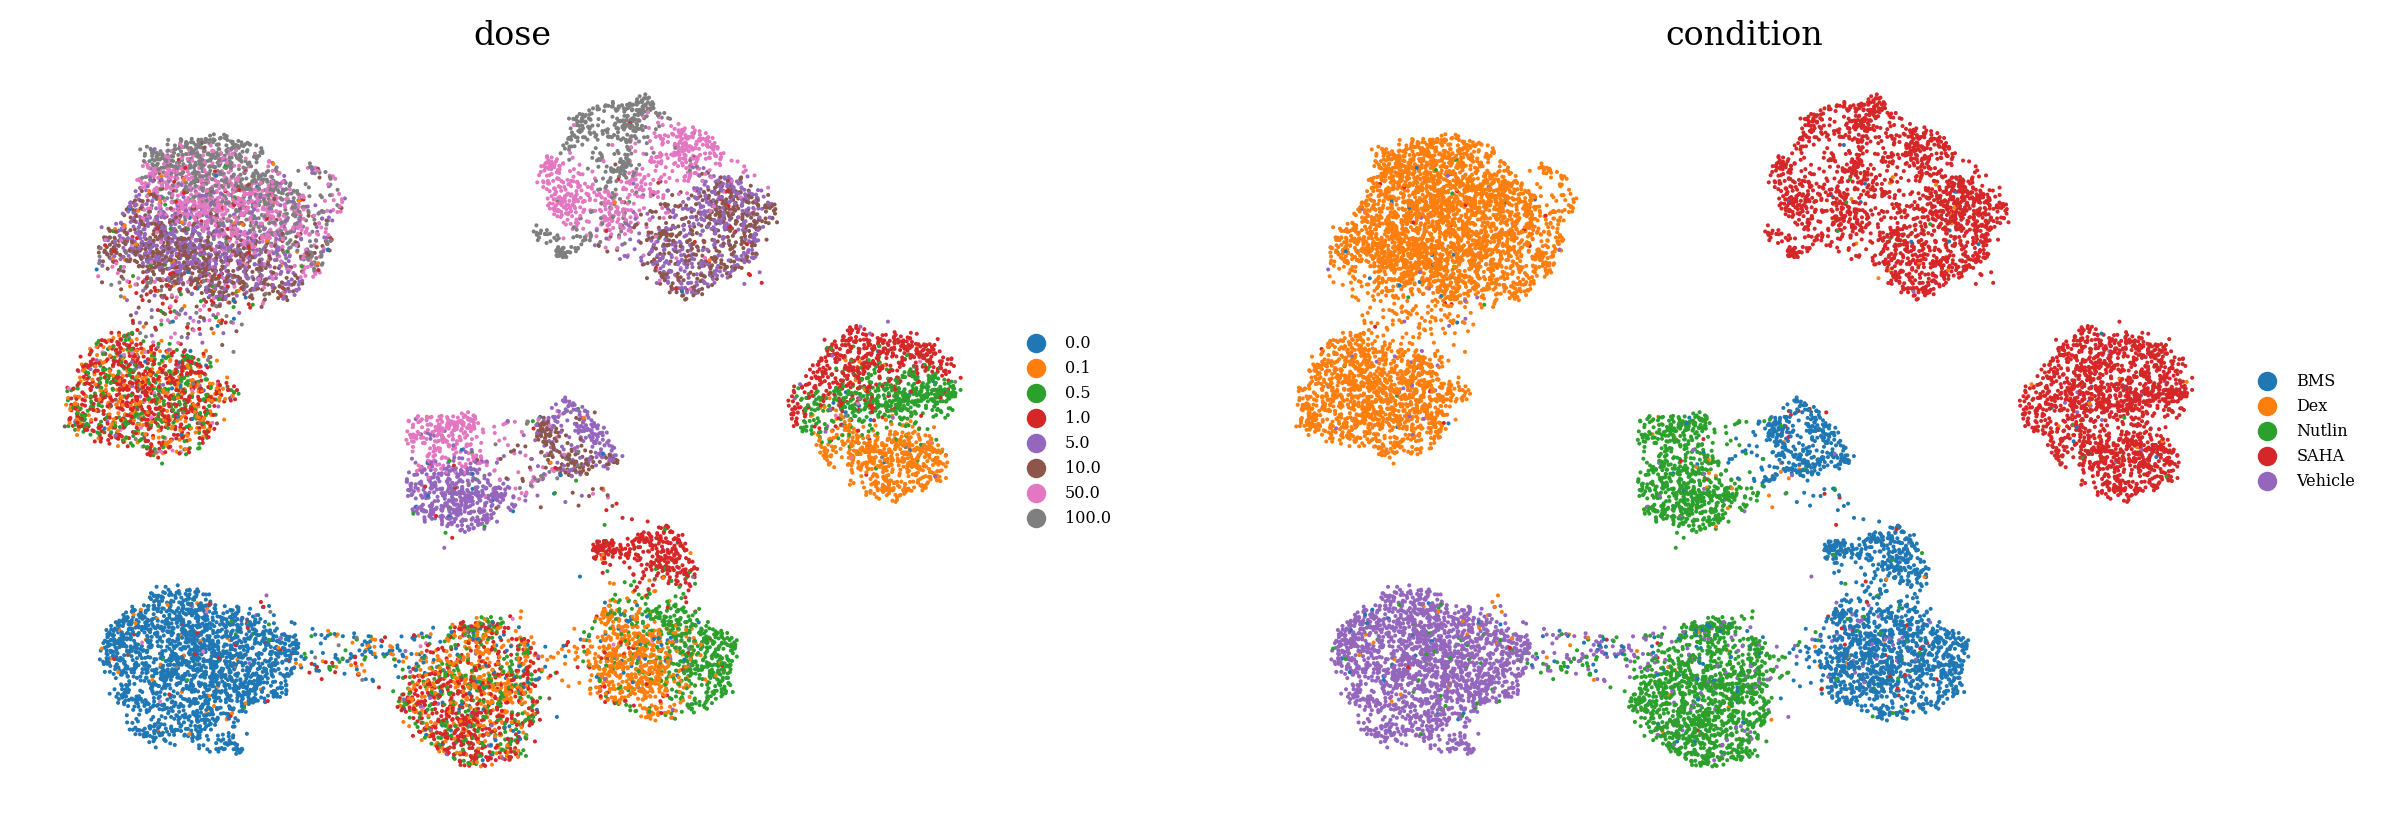

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [25]:
from tardis._disentanglementmanager import DisentanglementManager as DM

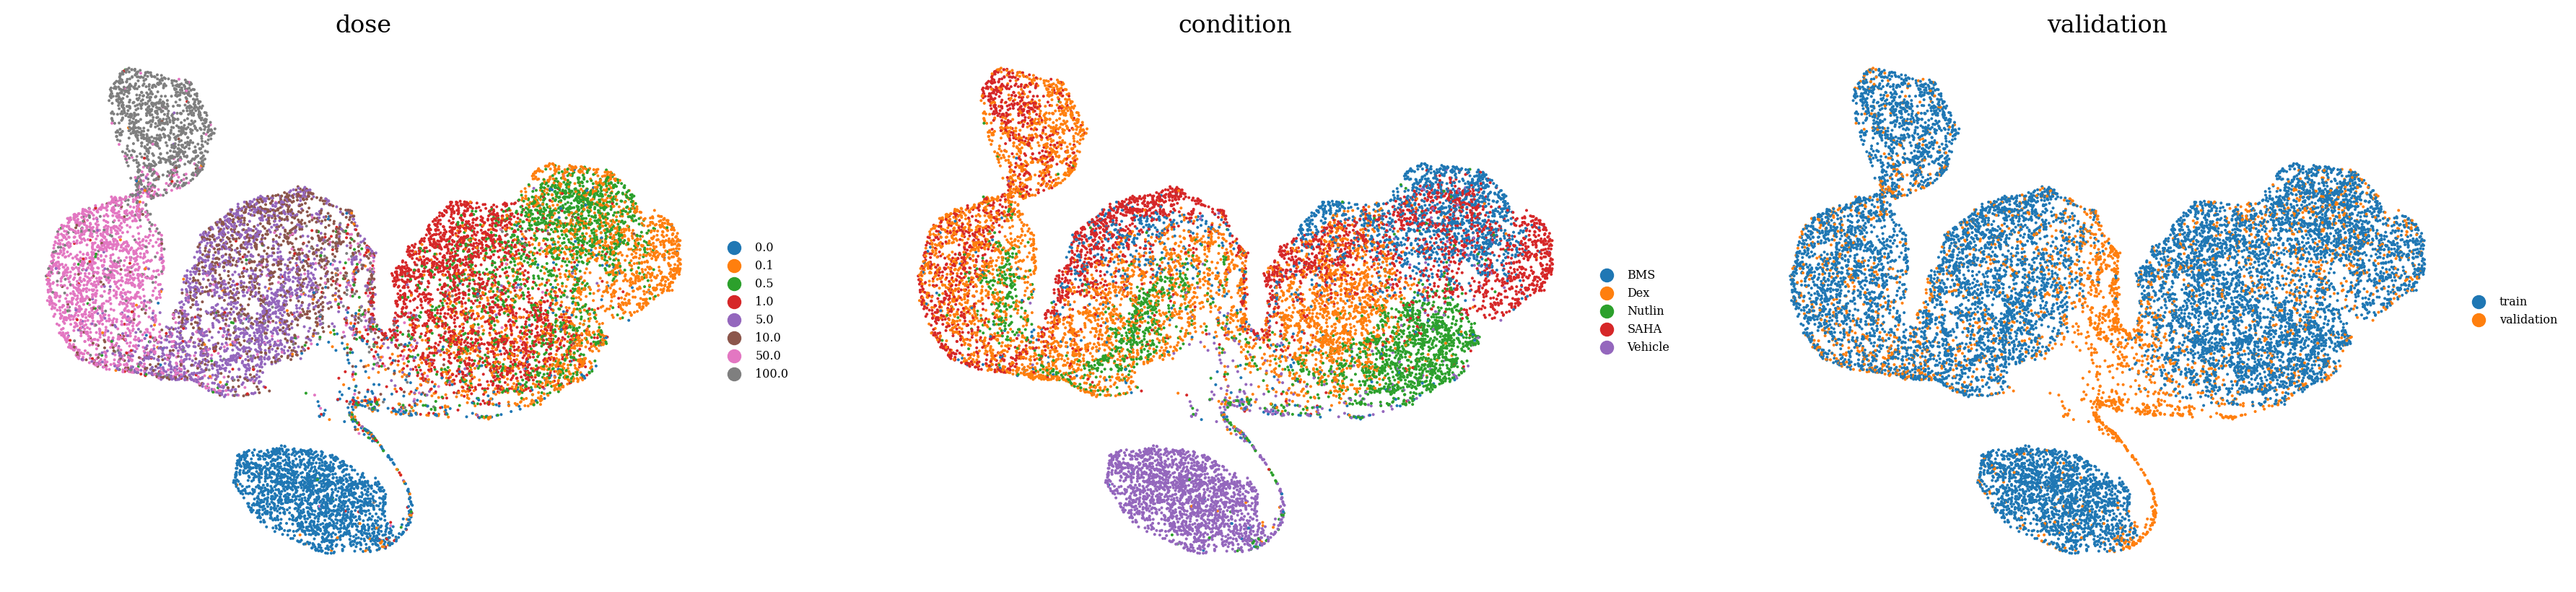

In [26]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

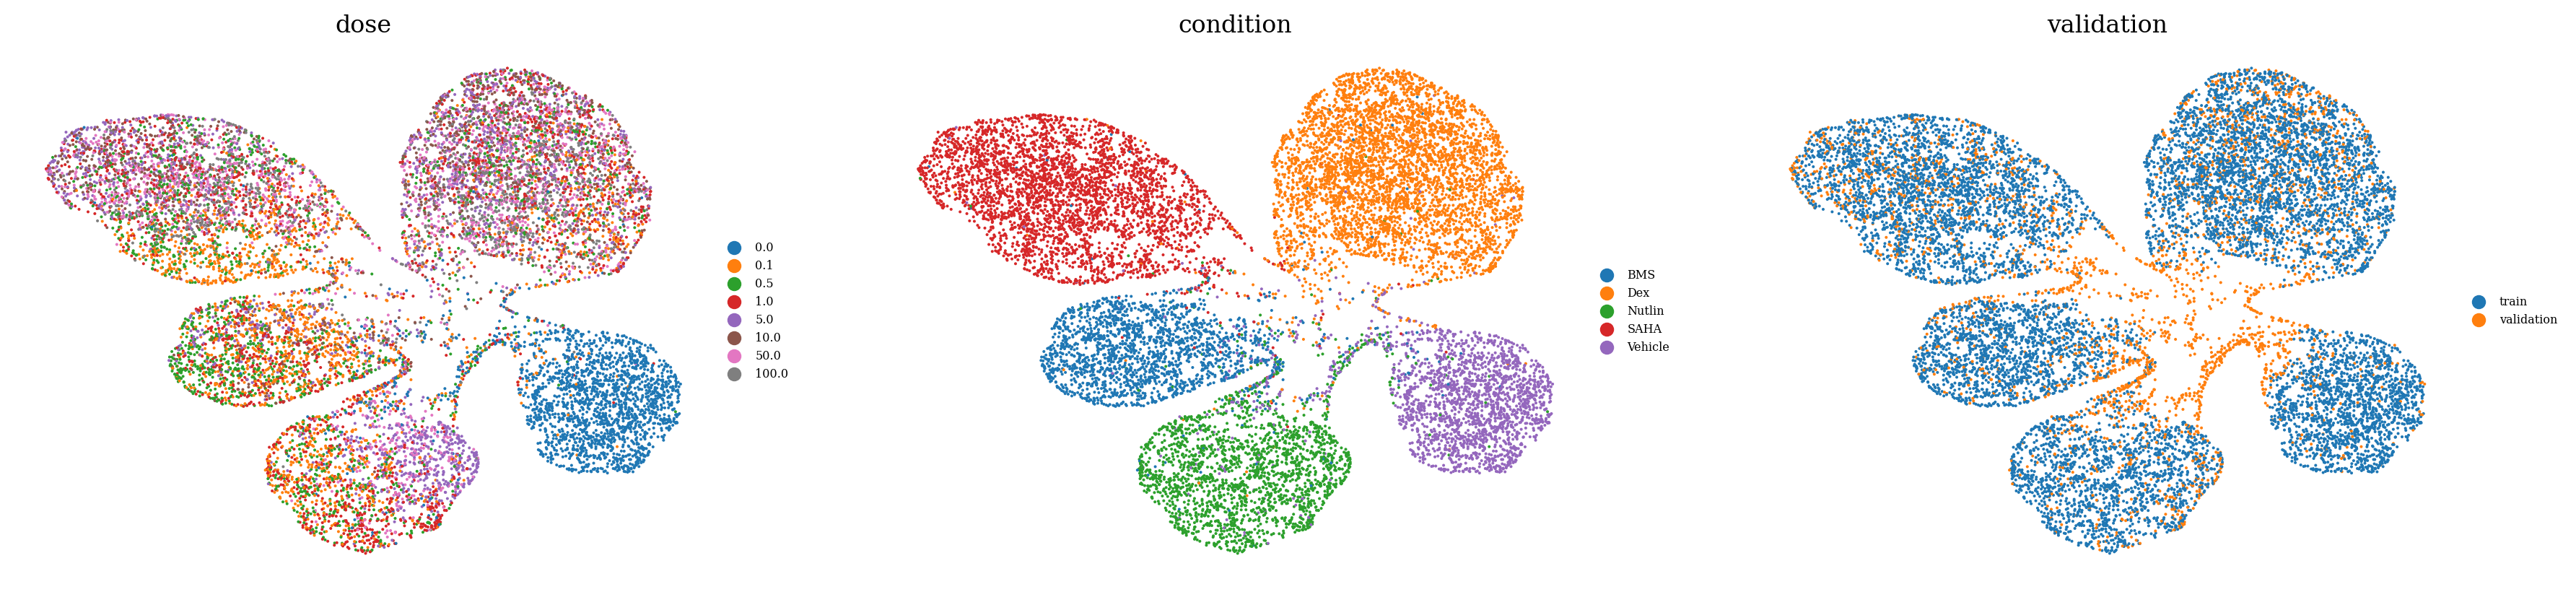

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"],
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [28]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [29]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


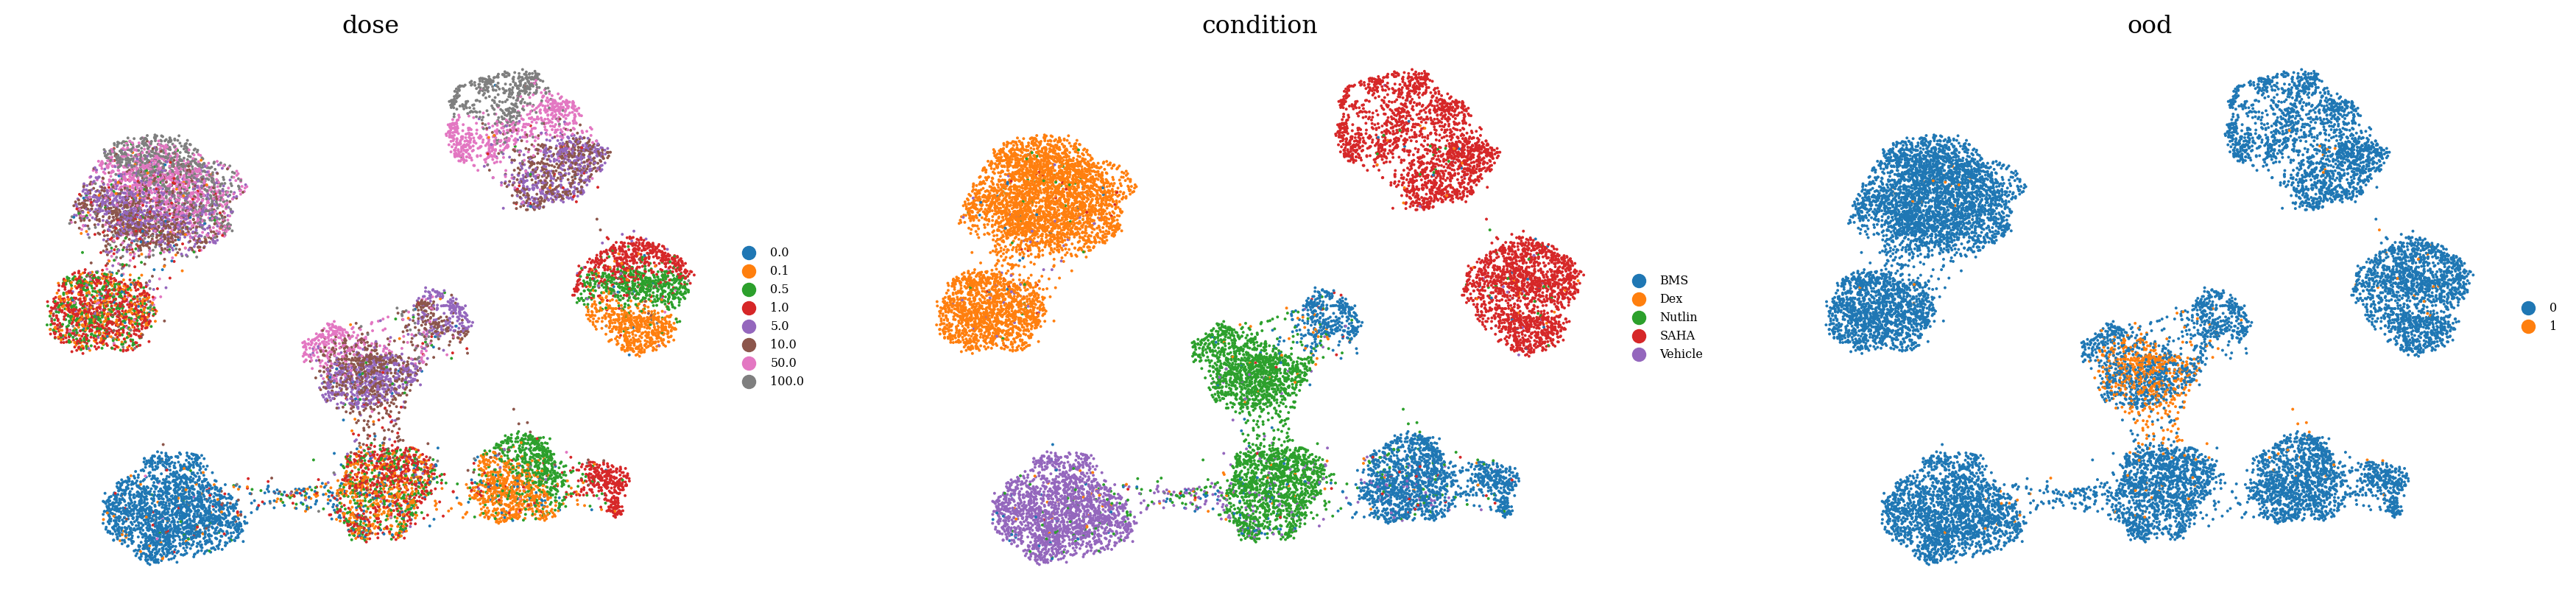

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
k = "dose_training"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


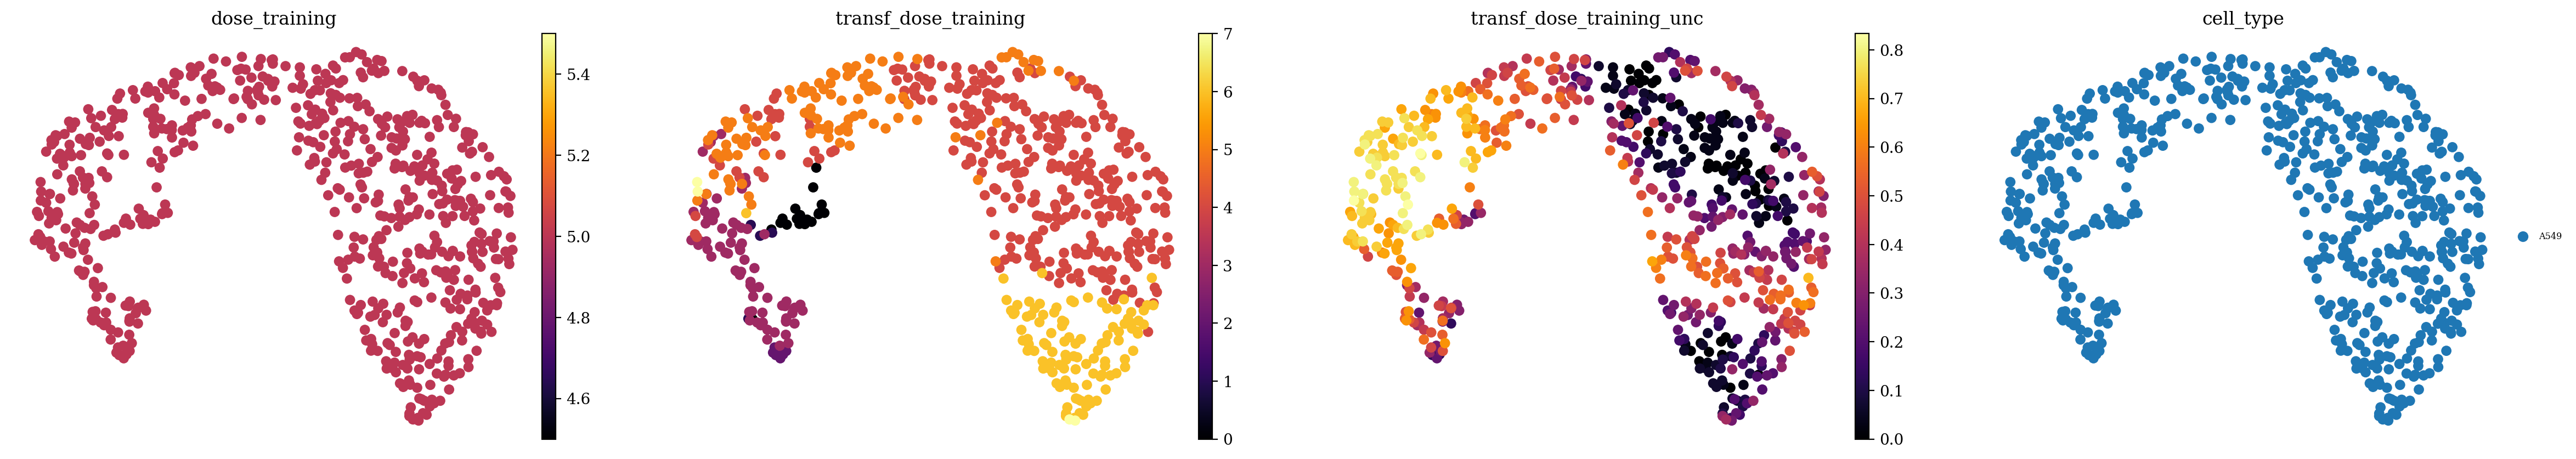

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [33]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.1613394216133942,
 'precision_macro': 0.125,
 'recall_macro': 0.020167427701674276,
 'f1_score_macro': 0.034731323722149404,
 'precision_micro': 0.1613394216133942,
 'recall_micro': 0.1613394216133942,
 'f1_score_micro': 0.1613394216133942,
 'precision_weighted': 1.0,
 'recall_weighted': 0.1613394216133942,
 'f1_score_weighted': 0.27785058977719523,
 'confusion_matrix': array([[  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [ 19,   4,   7,  74, 337, 106, 106,   4],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]])}

In [34]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.14658024441293632


In [35]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.1257173722233475
